# DATA SCIENCE CHALLENGE  
Thank you for your interest in SparkCognition. The following DS Challenge allows our team to better
understand your technical abilities and gives you some insight into the type of work SparkCognition’s
data scientists encounter on a daily basis.  
You will have three (3) days to complete the exercise which is estimated to take approximately two (2)
hours. Please aggregate your responses to a single notebook or file with associated comments and
include your full name in the file name. Acceptable submission formats include .ipynb, .html, and .pdf.
Each section will be weighted equally in the evaluation. In addition, please note that you will be
evaluated on your quality of coding, thought process, and clarity in communication.

## By Varishu Pant
## +91-7042626395
## varishupant@gmail.com
### Looking forward to connect with you!

# Exercise 1: Data Preparation and Preprocessing
Please complete the following exercise, using comments in your code to explain your reasoning.
You have been provided with medical survey data that includes responses from an initial screening
(demographic questionnaire), as well as a follow-up medical examination (blood pressure) with lab tests
(cholesterol). This data is a subset taken from the NHANES 2005-2006 Survey and provided in the SAS
XPT format. You can refer to the CDC website at https://wwwn.cdc.gov/Nchs/Nhanes/ and the links
below for detailed descriptions of the features in each dataset.
Please clean and prepare the dataset for modeling, incorporating the following instructions.

In [385]:
#Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import tensorflow as tf
from pyod.models.pca import PCA
from sklearn.ensemble import IsolationForest
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
from tensorflow.keras.constraints import max_norm as maxnorm
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, Dense ,Dropout
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score,classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier    
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
%matplotlib inline

Instructions:
1. Use python to load DEMO_D.csv, BPX_D.csv, and TCHOL_D.csv as pandas data frames.
Merge the 3 datasets but keep only the records that appear in all 3 datasets .

In [386]:
#Reading Data
demo_1=pd.read_csv('DEMO_D.csv')
bp=pd.read_csv('BPX_D.csv')
chol=pd.read_csv('TCHOL_D.csv')

In [387]:
demo_1.head()

SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEMN  RIDAGEEX      RIDAGEYR  \
0  31127.0       4.0       2.0       1.0      11.0      12.0  5.397605e-79   
1  31128.0       4.0       2.0       2.0     132.0     132.0  1.100000e+01   
2  31129.0       4.0       2.0       1.0     189.0     190.0  1.500000e+01   
3  31130.0       4.0       2.0       2.0       NaN       NaN  8.500000e+01   
4  31131.0       4.0       2.0       2.0     535.0     536.0  4.400000e+01   

   RIDRETH1  DMDEDUC3  DMDEDUC2  DMDSCHOL  
0       3.0       NaN       NaN       NaN  
1       4.0       4.0       NaN       1.0  
2       4.0      10.0       NaN       1.0  
3       3.0       NaN       4.0       NaN  
4       4.0       NaN       4.0       NaN

In [388]:
bp.head()

SEQN  PEASCST1  PEASCTM1  PEASCCT1  BPXCHR  BPQ150A
0  31127.0       1.0      41.0       NaN   100.0      NaN
1  31128.0       1.0     401.0       NaN     NaN      2.0
2  31129.0       1.0     664.0       NaN     NaN      1.0
3  31130.0       2.0       NaN       4.0     NaN      2.0
4  31131.0       1.0     827.0       NaN     NaN      2.0

In [389]:
chol.head()

SEQN  LBXTC  LBDTCSI
0  31128.0  129.0     3.34
1  31129.0  170.0     4.40
2  31130.0    NaN      NaN
3  31131.0  105.0     2.72
4  31132.0  147.0     3.80

In [390]:
print("Demographics Database has {} observations (customers) and {} columns (attributes).".format(demo_1.shape[0],demo_1.shape[1]))
print("Blood Pressure Database has {} observations (customers) and {} columns (attributes).".format(bp.shape[0],bp.shape[1]))
print("Cholestrol Database has {} observations (customers) and {} columns (attributes).".format(chol.shape[0],chol.shape[1]))

Demographics Database has 10348 observations (customers) and 11 columns (attributes).
Blood Pressure Database has 9950 observations (customers) and 6 columns (attributes).
Cholestrol Database has 8086 observations (customers) and 3 columns (attributes).


In [391]:
demo_1.SEQN.nunique(),bp.SEQN.nunique(),chol.SEQN.nunique() 

(10348, 9950, 8086)

SEQN is the unique id/key, so let's use it to merge the 3 datasets

In [392]:
df=pd.merge(demo_1,bp,on='SEQN',how='inner')  #Inner to keep only records that appear in both datasets
df=pd.merge(df,chol,on='SEQN',how='inner')  
df.shape

(8086, 18)

In [393]:
df.head()

SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEMN  RIDAGEEX  RIDAGEYR  \
0  31128.0       4.0       2.0       2.0     132.0     132.0      11.0   
1  31129.0       4.0       2.0       1.0     189.0     190.0      15.0   
2  31130.0       4.0       2.0       2.0       NaN       NaN      85.0   
3  31131.0       4.0       2.0       2.0     535.0     536.0      44.0   
4  31132.0       4.0       2.0       1.0     842.0     843.0      70.0   

   RIDRETH1  DMDEDUC3  DMDEDUC2  DMDSCHOL  PEASCST1  PEASCTM1  PEASCCT1  \
0       4.0       4.0       NaN       1.0       1.0     401.0       NaN   
1       4.0      10.0       NaN       1.0       1.0     664.0       NaN   
2       3.0       NaN       4.0       NaN       2.0       NaN       4.0   
3       4.0       NaN       4.0       NaN       1.0     827.0       NaN   
4       3.0       NaN       5.0       NaN       1.0     730.0       NaN   

   BPXCHR  BPQ150A  LBXTC  LBDTCSI  
0     NaN      2.0  129.0     3.34  
1     NaN      1.0  170.0     4.40  
2     NaN      2.0    NaN      NaN  
3     NaN      2.0  105.0     2.72  
4     NaN      2.0  147.0     3.80

### Variable Description

#### 1.SDDSRVYR 
represents the two-year data release cycle number. A value of “4” denotes NHANES 2005–2006.

#### 2.RIDSTATR 
is a recoded variable representing interview/examination status.

#### 3. RIDAGEMN 
is the respondent’s age in months at the time of the household screening interview. RIDAGEMN is provided for respondents who are less than 85 years of age (RIDAGEYR<85). If the exact date of birth is not provided by the respondent, the age in months is calculated based on the imputed age at the time of the screener interview.

#### 4. RIDAGEEX 
is age in months at the Mobile Examination Center (MEC) examination. RIDAGEEX is provided for subjects under 85 years of age at the time of household screening (RIDAGEYR<85). A total of 25 respondents who were under 85 years of age at the time of the household screening interview have missing data on RIDAGEEX because their exact date of birth was not available. RIDAGEEX was not calculated for individuals who have imputed values for age.

#### 5. RIDAGEYR: 
Age in years at the time of the screening interview is reported for survey participants between the ages of 1 and 84 years of age. All adults who were 85 years and older have RIDAGEYR values of ‘85’. The reporting of age in single years for adults 85 years and older was determined to be a disclosure risk. In NHANES 2005-2006, the weighted mean age for participants 85 years and older is 89 years.

The respondents’ actual or imputed date of birth was used to calculate RIDAGEYR. The procedure that NCHS used to impute age at screener when the date of birth is missing or refused, but the respondent’s age in years is provided is as follows: If month of birth is missing or not given, it is imputed as 7. If day of birth is missing or not given, it is imputed as 1. If the year of birth is missing or not given, it is imputed as the year of the screening interview minus the age in years provided by the respondent during the screening interview. Corrections are made to this imputed information for respondents who are less than 1 year of age at the time of screening.

#### 6. RIDRETH1:
RIDRETH1 was derived from responses to the survey questions on race and Hispanic origin. Respondents who self-identified as “Mexican American” were coded as such (i.e., RIDRETH1=1) regardless of their other race-ethnicity identities. Otherwise, self-identified “Hispanic” ethnicity would result in code “2, Other Hispanic” in the RIDRETH1 variable. All other non-Hispanic participants would then be categorized based on their self-reported races: non-Hispanic white (RIDRETH1=3), non-Hispanic black (RIDRETH1=4), and other non-Hispanic race including non-Hispanic multiracial (RIDRETH1=5).

RIDRETH1 is the only race/ethnicity variable in the 2005-2006 Demographics data file. The Demographics files that were released for NHANES 1999-2004 had a variable called ‘RIDRETH2’ that provided an analytic link to the NHANES III race/ethnicity variable. RIDRETH2 is not included in the NHANES 2005-2006 Demographics file. The NHANES Analytic Guidelines provide additional information.

#### 7. DMDEDUC3:
This variable provides information on the highest grade or level of education completed by respondents 6-19 years of age. The responses were recoded by NCHS as follows: single years of education (grades 1-12), high school graduate/GED, and post-high school. Code ‘66’ (less than 9th grade) was used to categorize older youth who had very low education levels.

#### 8. DMDEDUC2:
This variable is the highest grade or level of education completed by adults 20 years and older. The response categories are: less than 9th grade education, 9-11th grade education (includes 12th grade and no diploma), High school graduate/GED, some college or associates (AA) degree, and college graduate or higher. DMDEDUC2 provides more detailed information on education levels of adults compared to the categories released with the NHANES 1999-2004 Demographics files. The NHANES 1999-2004 Demographics data files will be revised to include DMDEDUC2. Please refer to the Analytic Notes for additional information on education level variables.

#### 9. DMDSCHOL: 
This variable is school attendance status. It is asked for respondents 6-19 years of age.

#### 10. RIAGENDR - Gender
Variable Name:RIAGENDRSAS Label:Gender  
English Text:Gender of the sample person  
Target:Both males and females 0 YEARS - 150 YEARS

#### 11. PEASCST1 - Blood Pressure Status
Code or Value:1,2,3,.
Value Description:Complete,Partial,Not Done,Missing

#### 12. PEASCTM1 - Blood Pressure Time in Seconds
2 to 2679- Range of values
. - Missing

#### 13. PEASCCT1 - Blood Pressure Comment
        Code	 Description	
            1	Safety exclusion
            2	SP refusal	
            3	No time	
            4	Physical limitation	
            5	Communication problem	
            7	SP ill/emergency
            14	Interrupted	
            56	Came late/left early	
            84	SP with child
            99	Other, specify	
            .	Missing	
            
#### 14. BPXCHR - 60 sec HR (30 sec HR * 2)
0 to 288- Range of values  
. - Missing

#### 15. BPQ150A - Had food in the past 30 minutes?
1- Yes  
2- No  
.- Missing  

#### 16. LBXTC - Total cholesterol (mg/dL)
78 to 615- Range of values
. - Missing

## 2. The existing features RIDAGEMN and RIDAGEEX:
contain the age of the respondent at screening
and examination, respectively; however, both contain some missing values.  
## a. Create a new feature AGE_AT_SCREENING with no missing values 
that contains the most precise estimate of each respondent’s age (in months) at the time of screening.
Choose an appropriate strategy to estimate the missing values and explain your
reasoning.

In [394]:
print("\nMissing values in each column:\n{}".format(df.isnull().sum()*100/df.shape[0]))
print("\nData Types:\n{}".format(df.dtypes))


Missing values in each column:
SEQN         0.000000
SDDSRVYR     0.000000
RIDSTATR     0.000000
RIAGENDR     0.000000
RIDAGEMN     1.830324
RIDAGEEX     2.090032
RIDAGEYR     0.000000
RIDRETH1     0.000000
DMDEDUC3    59.040317
DMDEDUC2    40.972050
DMDSCHOL    61.958941
PEASCST1     0.000000
PEASCTM1     3.475142
PEASCCT1    95.547860
BPXCHR      95.597329
BPQ150A      7.803611
LBXTC        8.978481
LBDTCSI      8.978481
dtype: float64

Data Types:
SEQN        float64
SDDSRVYR    float64
RIDSTATR    float64
RIAGENDR    float64
RIDAGEMN    float64
RIDAGEEX    float64
RIDAGEYR    float64
RIDRETH1    float64
DMDEDUC3    float64
DMDEDUC2    float64
DMDSCHOL    float64
PEASCST1    float64
PEASCTM1    float64
PEASCCT1    float64
BPXCHR      float64
BPQ150A     float64
LBXTC       float64
LBDTCSI     float64
dtype: object


In [395]:
df.RIDAGEMN.describe(),df.RIDAGEYR.describe()

(count    7938.000000
 mean      400.234316
 std       261.916565
 min        72.000000
 25%       182.000000
 50%       315.000000
 75%       596.000000
 max      1019.000000
 Name: RIDAGEMN, dtype: float64,
 count    8086.000000
 mean       33.858150
 std        22.720599
 min         6.000000
 25%        15.000000
 50%        27.000000
 75%        51.000000
 max        85.000000
 Name: RIDAGEYR, dtype: float64)

*Max of RIDAGEMN is 1 month short of 85 years. As provided in its description, this variable has values for Age<85*

In [396]:
df[df.RIDAGEMN.isnull()]['RIDAGEYR'].value_counts(normalize=True)

85.0    1.0
Name: RIDAGEYR, dtype: float64

*All missing values in RIDAGEMN is for RIDAGEYR 85. As we know from this variable's description, for age 85 or above, RIDAGEYR will be 85.*

In [397]:
df[df.RIDAGEYR==85].isnull().sum()*100/df[df.RIDAGEYR==85].shape[0]

SEQN          0.000000
SDDSRVYR      0.000000
RIDSTATR      0.000000
RIAGENDR      0.000000
RIDAGEMN    100.000000
RIDAGEEX    100.000000
RIDAGEYR      0.000000
RIDRETH1      0.000000
DMDEDUC3    100.000000
DMDEDUC2      0.000000
DMDSCHOL    100.000000
PEASCST1      0.000000
PEASCTM1      8.783784
PEASCCT1     89.864865
BPXCHR      100.000000
BPQ150A       8.108108
LBXTC         9.459459
LBDTCSI       9.459459
dtype: float64

*As expected, for all observations where RIDAGEYR is 85, RIDAGEMN and RIDAGEEX are missing*

##### Now,we know that in NHANES 2005-2006, the weighted mean age for participants 85 years and older is 89 years. Let's confirm if all observations are from NHANES

In [398]:
df.SDDSRVYR.value_counts() 

4.0    8086
Name: SDDSRVYR, dtype: int64

##### Since A value of “4” denotes NHANES 2005–2006, we can verify the same and go ahead with imputation

#### Keeping in mind that we have the option to impute using 89 years, let's explore other options:

To do that, first let's take a look at the distribution of the variable RIDAGEMN

<AxesSubplot:xlabel='RIDAGEMN', ylabel='Count'>

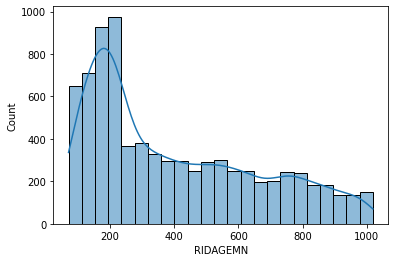

In [399]:
plt.figure()
sns.histplot(df.RIDAGEMN,kde=True)

*Since the variable is highly skewed, mean imputation is not the way to go.Median,i.e 315 months or 26.25 ~ 27 years is also not an option since participant is 85+ years old. We can also use a model like KNN but that's not recommended as in this case, the missing values are not at random. In fact, there is a clear winner here:*

#### *The weighted mean involves multiplying each data point in a set by a value which is determined by some characteristic of whatever contributed to the data point. Since we know that characteristic here is the person's age in years, we should impute with 89 years(in months) or 1068*

In [400]:
df['RIDAGEMN']=df.RIDAGEMN.fillna(1068)

## b. Create a second feature AGE_AT_EXAM with no missing values 
that contains the most precise estimate of each respondent’s age (in months) at the time of the follow-up
examination. Choose an appropriate strategy to estimate the missing values and explain
your reasoning.

In [401]:
df.RIDSTATR.value_counts()  #Both Interviewed and MEC examined

2.0    8086
Name: RIDSTATR, dtype: int64

So we know that each participant in our data has been interviewed and examined.

In [402]:
pd.Series(df.RIDAGEEX-df.RIDAGEMN).value_counts(normalize=True)

1.0    0.608185
0.0    0.284199
2.0    0.106101
3.0    0.001516
dtype: float64

*Calculating difference in months between RIDAGEEX and RIDAGEMN, we see that most people were examined 1 month after the initial interview screening*

Let's see if this patterns holds through out the ages or changes with other variables:

In [403]:
df['Age_Diff']=df.RIDAGEEX-df.RIDAGEMN  #Creating variable 
df['Age_Year_Bucket']=pd.cut(df.RIDAGEYR,bins=[-np.inf,18,30,40,50,60,70,80,np.inf])
pd.crosstab(df.Age_Year_Bucket,df.Age_Diff)

Age_Diff         0.0   1.0  2.0  3.0
Age_Year_Bucket                     
(-inf, 18.0]     869  1829  347    2
(18.0, 30.0]     408   830  128    1
(30.0, 40.0]     210   527   88    3
(40.0, 50.0]     229   471   86    2
(50.0, 60.0]     189   385   57    0
(60.0, 70.0]     176   405   62    2
(70.0, 80.0]     119   270   55    2
(80.0, inf]       50    98   17    0

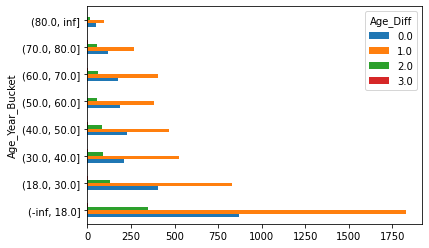

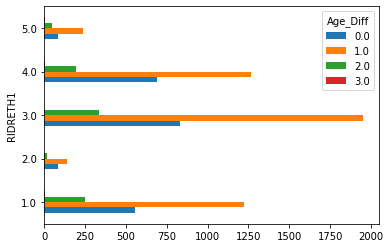

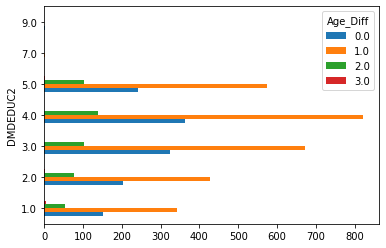

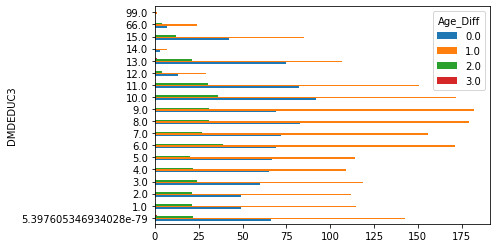

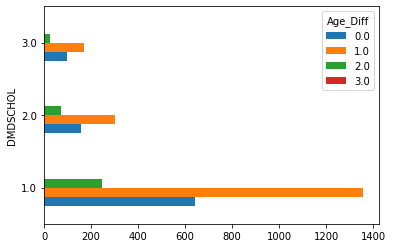

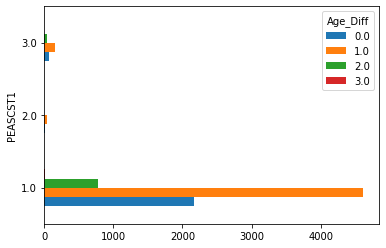

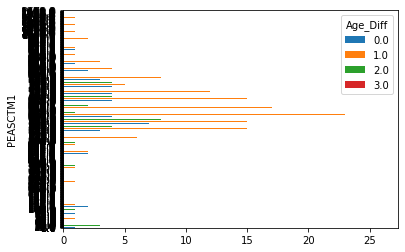

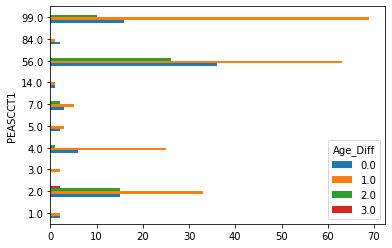

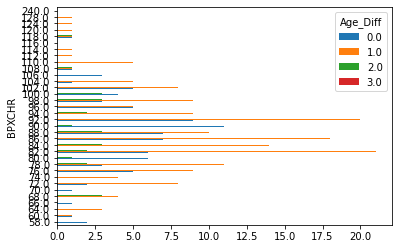

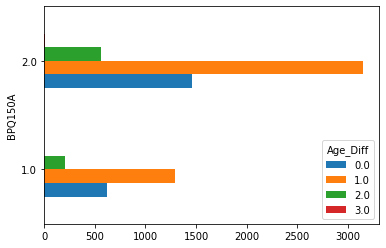

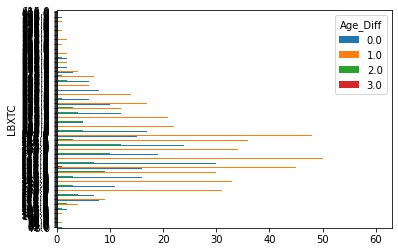

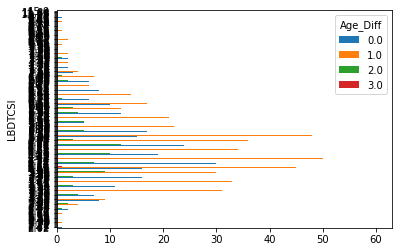

In [404]:
pd.crosstab(df.Age_Year_Bucket,df.Age_Diff).plot(kind='barh')
pd.crosstab(df.RIDRETH1,df.Age_Diff).plot(kind='barh')
pd.crosstab(df.DMDEDUC2,df.Age_Diff).plot(kind='barh')
pd.crosstab(df.DMDEDUC3,df.Age_Diff).plot(kind='barh')
pd.crosstab(df.DMDSCHOL,df.Age_Diff).plot(kind='barh')
pd.crosstab(df.PEASCST1,df.Age_Diff).plot(kind='barh')
pd.crosstab(df.PEASCTM1,df.Age_Diff).plot(kind='barh')
pd.crosstab(df.PEASCCT1,df.Age_Diff).plot(kind='barh')
pd.crosstab(df.BPXCHR,df.Age_Diff).plot(kind='barh')
pd.crosstab(df.BPQ150A,df.Age_Diff).plot(kind='barh')
pd.crosstab(df.LBXTC,df.Age_Diff).plot(kind='barh')
pd.crosstab(df.LBDTCSI,df.Age_Diff).plot(kind='barh')

plt.show()

#### *As we can see from the visualizations above, no matter the variable, Age Difference is 1 month for most participants. Using that fact to our advantage, we can impute the missing values in RIDAGEEX by RIDAGEMN+1 months*

In [405]:
df[df.RIDAGEEX.isnull()]['RIDAGEYR'].value_counts(normalize=True)

85.0    0.875740
26.0    0.017751
44.0    0.011834
84.0    0.011834
24.0    0.005917
9.0     0.005917
16.0    0.005917
10.0    0.005917
29.0    0.005917
82.0    0.005917
70.0    0.005917
18.0    0.005917
13.0    0.005917
15.0    0.005917
53.0    0.005917
28.0    0.005917
20.0    0.005917
50.0    0.005917
Name: RIDAGEYR, dtype: float64

In [406]:
df.RIDAGEEX.describe()

count    7917.000000
mean      400.949476
std       261.822792
min        72.000000
25%       183.000000
50%       316.000000
75%       597.000000
max      1019.000000
Name: RIDAGEEX, dtype: float64

In [407]:
df['RIDAGEEX']=pd.Series(np.where(df.RIDAGEEX.isnull(),df.RIDAGEMN+1,df.RIDAGEMN))
df.RIDAGEEX.describe()

count    8086.000000
mean      412.477492
std       274.557680
min        72.000000
25%       184.000000
50%       324.000000
75%       614.000000
max      1069.000000
Name: RIDAGEEX, dtype: float64

## 3.
The existing features DMDEDUC3 and DMDEDUC2 contain categorical responses for each
respondent’s highest level of education completed: however, the categories are somewhat
overlapping and complicated.
## a. Create a new categorical feature HIGHEST_EDUCATION
with the following categories:
ELEMENTARY (did not graduate HS, or currently in grades K-12), HIGHSCHOOL
(graduated or GED), and COLLEGE (4 year graduates only). This feature should reflect
the highest level of education completed for each respondent, from among the 3
options. Choose an appropriate strategy to fill in any missing values and explain your
reasoning.

#### DMDEDUC3:
This variable provides information on the highest grade or level of education completed by respondents 6-19 years of age. The responses were recoded by NCHS as follows: single years of education (grades 1-12), high school graduate/GED, and post-high school. Code ‘66’ (less than 9th grade) was used to categorize older youth who had very low education levels.

Code-  
0-Never Attended/Kindergarten Only  
1-12-Grades 1 to 12, No diploma  
13- High School Graduate  
14- GED or equivalent  
15- More than High School  
55- Less than 5th Grade  
66- Less than 9th Grade  
77- Refused  
99- Don't know  
. - Missing  

####  DMDEDUC2:
This variable is the highest grade or level of education completed by adults 20 years and older. The response categories are: less than 9th grade education, 9-11th grade education (includes 12th grade and no diploma), High school graduate/GED, some college or associates (AA) degree, and college graduate or higher. DMDEDUC2 provides more detailed information on education levels of adults compared to the categories released with the NHANES 1999-2004 Demographics files. The NHANES 1999-2004 Demographics data files will be revised to include DMDEDUC2. Please refer to the Analytic Notes for additional information on education level variables.

1- Less than 9h Grade  
2- 9-11th grade (12th with no diploma)  
3- High school grad/ GED or equivalent  
4- Some college or AA degree  
5- College graduate or above  
7- Refused  
9- Don't know  
.- Missing  

In [408]:
s=df.isnull().sum()*100/df.shape[0]
s[s>0]                                    #nulls in percentages

DMDEDUC3    59.040317
DMDEDUC2    40.972050
DMDSCHOL    61.958941
PEASCTM1     3.475142
PEASCCT1    95.547860
BPXCHR      95.597329
BPQ150A      7.803611
LBXTC        8.978481
LBDTCSI      8.978481
Age_Diff     2.090032
dtype: float64

Using what we know about these 2 variables from their description, let's find if there is any missing value at random:

In [409]:
df[((df.DMDEDUC3.isnull()) & (df.RIDAGEYR<20))] #One missing value

SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEMN  RIDAGEEX  RIDAGEYR  \
2633  34506.0       4.0       2.0       2.0      72.0      72.0       6.0   

      RIDRETH1  DMDEDUC3  DMDEDUC2  DMDSCHOL  PEASCST1  PEASCTM1  PEASCCT1  \
2633       1.0       NaN       NaN       NaN       1.0     108.0       NaN   

      BPXCHR  BPQ150A  LBXTC  LBDTCSI  Age_Diff Age_Year_Bucket  
2633    76.0      NaN    NaN      NaN       0.0    (-inf, 18.0]

In [410]:
df[((df.DMDEDUC2.isnull()) & (df.RIDAGEYR>=20))]  #No missing value

Empty DataFrame
Columns: [SEQN, SDDSRVYR, RIDSTATR, RIAGENDR, RIDAGEMN, RIDAGEEX, RIDAGEYR, RIDRETH1, DMDEDUC3, DMDEDUC2, DMDSCHOL, PEASCST1, PEASCTM1, PEASCCT1, BPXCHR, BPQ150A, LBXTC, LBDTCSI, Age_Diff, Age_Year_Bucket]
Index: []

*After checking using Age as a factor, we see that DMDEDUC3 has 1 missing value. That observation has most variables missing and since there's only one, let's drop it.*

In [411]:
df=df[df.SEQN!=34506]         #Dropping the missing value

In [412]:
df.DMDEDUC2.isnull().sum()+df.DMDEDUC3.isnull().sum() == df.shape[0] 
#Sanity check to confirm we have all values

True

#### Now let's group these 2 variable codes into 3 wide options and then combine DMDEDUC2 and DMDEDUC3 into one column

In [413]:
cond=[df.DMDEDUC2.isin([1,2]),
       df.DMDEDUC2==3,
       df.DMDEDUC2==5,
     df.DMDEDUC2.isnull()]
choice=['ELEMENTARY','HIGHSCHOOL','COLLEGE','N.A.']
df['HE1']=np.select(condlist=cond,choicelist=choice,default='OTHERS')

elem=np.arange(0,13).tolist()
elem.append(55)
elem.append(66)
cond=[df.DMDEDUC3.isin(elem),
     df.DMDEDUC3.isin([13,14]),
     df.DMDEDUC3.isnull()]
choice=['ELEMENTARY','HIGHSCHOOL','N.A.']
df['HE2']=np.select(condlist=cond,choicelist=choice,default='OTHERS')

In [414]:
df.HE1.astype(str).value_counts(),df.HE2.astype(str).value_counts()

(N.A.          3312
 OTHERS        1368
 ELEMENTARY    1330
 HIGHSCHOOL    1136
 COLLEGE        939
 Name: HE1, dtype: int64,
 N.A.          4773
 ELEMENTARY    2726
 OTHERS         372
 HIGHSCHOOL     214
 Name: HE2, dtype: int64)

In [415]:
df['HIGHEST_EDUCATION']=np.where(df.HE1=='N.A.',df.HE2,df.HE1)
df.HIGHEST_EDUCATION.value_counts(normalize=True)

ELEMENTARY    0.501670
OTHERS        0.215213
HIGHSCHOOL    0.166976
COLLEGE       0.116141
Name: HIGHEST_EDUCATION, dtype: float64

*In the end, we keep 4 categories in this variable. 3 as defined in problem and 4th that comprises what's left after removing null value*

## 4.
The file DEMO_RETIRED.CSV contains a single feature named RETIRED which is a binary flag
indicating whether the respondent is retired (1) or not (0). This feature has some missing values.
## a. Suggest an appropriate strategy to fill in the missing values.
Justify your approach using
graphs or statistics.

In [416]:
demo_ret=pd.read_csv('DEMO_RETIRED.csv')
demo_ret.shape                             #Reading Data and checking it's shape

(10348, 2)

In [417]:
demo_ret.isnull().sum()  

SEQN          0
RETIRED    2262
dtype: int64

In [418]:
demo_ret[demo_ret.SEQN.isin(df.SEQN)==False].isnull().sum()  

SEQN          0
RETIRED    2262
dtype: int64

*All missing values are for observations other than those present in all 3 datasets that we've been working on till now.
So let's create a new dataset wherein we keep all observations as in DEMO_RETIRED while joining in the rest of the variables*

In [419]:
df_ret=pd.merge(demo_1,demo_ret,how='right')
df_ret=pd.merge(df_ret,chol,how='left')
df_ret=pd.merge(df_ret,bp,how='left')
df_ret.shape

(10348, 19)

In [420]:
df_ret.isnull().sum()*100/df_ret.shape[0]          #Missing values

SEQN         0.000000
SDDSRVYR     0.000000
RIDSTATR     0.000000
RIAGENDR     0.000000
RIDAGEMN     1.642830
RIDAGEEX     5.517974
RIDAGEYR     0.000000
RIDRETH1     0.000000
DMDEDUC3    66.834171
DMDEDUC2    51.884422
DMDSCHOL    69.230769
RETIRED     21.859296
LBXTC       28.875145
LBDTCSI     28.875145
PEASCST1     3.846154
PEASCTM1     6.832238
PEASCCT1    95.767298
BPXCHR      79.049092
BPQ150A     27.957093
dtype: float64

##### Preprocessing and Feature Engineering

In [421]:
#Let's verify the assumption that our new data is similar to previous data
df_ret[df_ret.RIDAGEMN.isnull()]['RIDAGEYR'].value_counts(normalize=True)         #Verified

85.0    1.0
Name: RIDAGEYR, dtype: float64

So we can fill nulls for RIDAGEMN and RIDAGEEX as we did before

In [422]:
df_ret['RIDAGEMN']=df_ret.RIDAGEMN.fillna(1068)
df_ret['RIDAGEEX']=pd.Series(np.where(df_ret.RIDAGEEX.isnull(),df_ret.RIDAGEMN+1,df_ret.RIDAGEMN))

*Similarly let's verify for DMDEDUC2 and DMDEDUC3*

In [423]:
df_ret[((df_ret.DMDEDUC3.isnull()) & (df_ret.RIDAGEYR<20))].shape            #Lot of missing values

(1937, 19)

In [424]:
df_ret[((df_ret.DMDEDUC3.isnull()) & (df_ret.RIDAGEYR<20))].describe()        #Characteristics of nulls

SEQN  SDDSRVYR     RIDSTATR     RIAGENDR      RIDAGEMN  \
count   1937.000000    1937.0  1937.000000  1937.000000  1.937000e+03   
mean   36279.163655       4.0     1.962829     1.485803  2.951626e+01   
std     3014.015719       0.0     0.189229     0.499927  2.094290e+01   
min    31127.000000       4.0     1.000000     1.000000  5.397605e-79   
25%    33638.000000       4.0     2.000000     1.000000  1.100000e+01   
50%    36272.000000       4.0     2.000000     1.000000  2.600000e+01   
75%    38935.000000       4.0     2.000000     2.000000  4.700000e+01   
max    41470.000000       4.0     2.000000     2.000000  7.200000e+01   

           RIDAGEEX      RIDAGEYR     RIDRETH1  DMDEDUC3  DMDEDUC2  DMDSCHOL  \
count  1.937000e+03  1.937000e+03  1937.000000       0.0       0.0       0.0   
mean   2.955550e+01  2.000000e+00     2.571502       NaN       NaN       NaN   
std    2.094757e+01  1.725478e+00     1.348466       NaN       NaN       NaN   
min    5.397605e-79  5.397605e-79     1.000000       NaN       NaN       NaN   
25%    1.100000e+01  5.397605e-79     1.000000       NaN       NaN       NaN   
50%    2.700000e+01  2.000000e+00     3.000000       NaN       NaN       NaN   
75%    4.700000e+01  3.000000e+00     4.000000       NaN       NaN       NaN   
max    7.200000e+01  6.000000e+00     5.000000       NaN       NaN       NaN   

       RETIRED  LBXTC  LBDTCSI     PEASCST1     PEASCTM1   PEASCCT1  \
count      1.0    0.0      0.0  1865.000000  1837.000000  78.000000   
mean       0.0    NaN      NaN     1.070777    97.939031  52.038462   
std        NaN    NaN      NaN     0.351772    84.364590  44.591200   
min        0.0    NaN      NaN     1.000000     2.000000   2.000000   
25%        0.0    NaN      NaN     1.000000    47.000000   2.000000   
50%        0.0    NaN      NaN     1.000000    68.000000  56.000000   
75%        0.0    NaN      NaN     1.000000   144.000000  99.000000   
max        0.0    NaN      NaN     3.000000   451.000000  99.000000   

             BPXCHR  BPQ150A  
count  1.813000e+03      0.0  
mean   1.108119e+02      NaN  
std    1.941627e+01      NaN  
min    5.397605e-79      NaN  
25%    9.800000e+01      NaN  
50%    1.100000e+02      NaN  
75%    1.220000e+02      NaN  
max    2.880000e+02      NaN

In [425]:
df_ret[((df_ret.DMDEDUC2.isnull()) & (df_ret.RIDAGEYR>=20))]  #No missing value

Empty DataFrame
Columns: [SEQN, SDDSRVYR, RIDSTATR, RIAGENDR, RIDAGEMN, RIDAGEEX, RIDAGEYR, RIDRETH1, DMDEDUC3, DMDEDUC2, DMDSCHOL, RETIRED, LBXTC, LBDTCSI, PEASCST1, PEASCTM1, PEASCCT1, BPXCHR, BPQ150A]
Index: []

*For missing values: These are participants who are less than or equal to 6 years old so logic dictates that we can say HIGHEST_EDUCATION for these observations will be 'ELEMENTARY'. Let's verify with existing data first:*

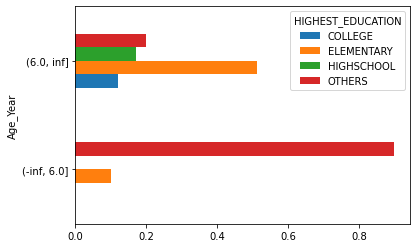

In [426]:
df['Age_Year']=pd.cut(df.RIDAGEYR,bins=[-np.inf,6,np.inf])
pd.crosstab(df.Age_Year,df.HIGHEST_EDUCATION).apply(lambda r: r/r.sum(), axis=1).plot(kind='barh')
plt.show()

In [427]:
df[df.Age_Year.astype(str)=='(-inf, 6.0]'].DMDEDUC3.astype(str).value_counts(normalize=True)

5.397605346934028e-79    0.900
1.0                      0.095
2.0                      0.005
Name: DMDEDUC3, dtype: float64

As we can see that DMDEDUC3 that has values for age 6-19, says that for 6 year olds, the value 5.39e-79 is most prominent but as we know from variable's description, this is not a valid value for this variable, hence it must be considered as missing.Taking that into account, let's see if there is any reason for this value:

In [428]:
df_ret[df_ret.DMDEDUC3==5.397605346934028e-79].describe()

SEQN  SDDSRVYR    RIDSTATR    RIAGENDR    RIDAGEMN    RIDAGEEX  \
count    244.000000     244.0  244.000000  244.000000  244.000000  244.000000   
mean   36341.782787       4.0    1.950820    1.508197   79.446721   79.495902   
std     3020.741658       0.0    0.216689    0.500960    5.532659    5.531428   
min    31147.000000       4.0    1.000000    1.000000   72.000000   72.000000   
25%    33495.750000       4.0    2.000000    1.000000   75.000000   75.000000   
50%    36418.000000       4.0    2.000000    2.000000   79.000000   79.000000   
75%    38867.500000       4.0    2.000000    2.000000   83.000000   83.000000   
max    41420.000000       4.0    2.000000    2.000000   96.000000   96.000000   

         RIDAGEYR    RIDRETH1      DMDEDUC3  DMDEDUC2  DMDSCHOL  RETIRED  \
count  244.000000  244.000000  2.440000e+02       0.0       0.0    232.0   
mean     6.233607    2.750000  5.397605e-79       NaN       NaN      0.0   
std      0.442981    1.369494  0.000000e+00       NaN       NaN      0.0   
min      6.000000    1.000000  5.397605e-79       NaN       NaN      0.0   
25%      6.000000    1.000000  5.397605e-79       NaN       NaN      0.0   
50%      6.000000    3.000000  5.397605e-79       NaN       NaN      0.0   
75%      6.000000    4.000000  5.397605e-79       NaN       NaN      0.0   
max      8.000000    5.000000  5.397605e-79       NaN       NaN      0.0   

            LBXTC     LBDTCSI    PEASCST1    PEASCTM1   PEASCCT1      BPXCHR  \
count  169.000000  169.000000  232.000000  225.000000  11.000000  223.000000   
mean   160.988166    4.163254    1.077586  112.386667  74.545455   88.798206   
std     27.133486    0.701645    0.363981  102.260508  31.979255   15.114863   
min     96.000000    2.480000    1.000000    5.000000   2.000000   60.000000   
25%    142.000000    3.670000    1.000000   49.000000  56.000000   82.000000   
50%    160.000000    4.140000    1.000000   78.000000  99.000000   88.000000   
75%    181.000000    4.680000    1.000000  162.000000  99.000000   96.000000   
max    224.000000    5.790000    3.000000  840.000000  99.000000  240.000000   

       BPQ150A  
count      2.0  
mean       2.0  
std        0.0  
min        2.0  
25%        2.0  
50%        2.0  
75%        2.0  
max        2.0

In [429]:
df[df_ret.DMDEDUC3==5.397605346934028e-79].shape[0]*100/df.shape[0]

2.3252937538651826

We see that this value is observed for 6-8 year olds but apart from that there's not much information to help us impute it manually. Since it's only 2.32 % of the data, we can drop it but there's no need because removing it from the data, we see :

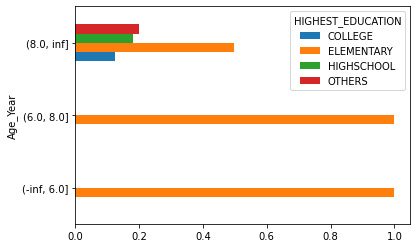

In [430]:
temp=df[df.DMDEDUC3!=5.397605346934028e-79]
temp['Age_Year']=pd.cut(temp.RIDAGEYR,bins=[-np.inf,6,8,np.inf])

pd.crosstab(temp.Age_Year,temp.HIGHEST_EDUCATION).apply(lambda r: r/r.sum(), axis=1).plot(kind='barh')
plt.show()

In [431]:
df_ret.DMDEDUC3.unique()   #Sanity checking other values

array([           nan, 4.00000000e+00, 1.00000000e+01, 9.00000000e+00,
       6.00000000e+00, 1.30000000e+01, 1.00000000e+00, 1.50000000e+01,
       3.00000000e+00, 5.39760535e-79, 5.00000000e+00, 2.00000000e+00,
       1.10000000e+01, 7.00000000e+00, 1.20000000e+01, 8.00000000e+00,
       6.60000000e+01, 1.40000000e+01, 9.90000000e+01])

There we go,result is as expected. Since we can safely say that for participants <=6 years old as well as 6-8 year olds, highest education will be ELEMENTARY, we can go ahead and create our variable HIGHEST_EDUCATION for the new data keeping in mind that for when we encounter the value 5.39e-79 (or null) in DMDEDUC3, we need to consider ELEMENTARY for HIGHEST_EDUCATION.
Also, we can use ELEMENTARY for all other null values in DMDEDUC3 for ages <=6 too

In [432]:
cond=[df_ret.DMDEDUC2.isin([1,2]),
       df_ret.DMDEDUC2==3,
       df_ret.DMDEDUC2==5,
     df_ret.DMDEDUC2.isnull()]
choice=['ELEMENTARY','HIGHSCHOOL','COLLEGE','N.A.']
df_ret['HE1']=np.select(condlist=cond,choicelist=choice,default='OTHERS')

elem=np.arange(0,13).tolist()
elem.append(55)
elem.append(66)
elem.append(5.397605346934028e-79)
cond=[df_ret.DMDEDUC3.isin(elem),
     df_ret.DMDEDUC3.isin([13,14]),
     df_ret.DMDEDUC3.isnull() & df_ret.RIDAGEYR <=6,
     df_ret.DMDEDUC3.isnull() & df_ret.RIDAGEYR >6]
choice=['ELEMENTARY','HIGHSCHOOL','ELEMENTARY','N.A.']
df_ret['HE2']=np.select(condlist=cond,choicelist=choice,default='OTHERS')
df_ret['HIGHEST_EDUCATION']=np.where(df_ret.HE1=='N.A.',df_ret.HE2,df_ret.HE1)
df_ret.HIGHEST_EDUCATION.value_counts(normalize=True)
#Final Variable Created

ELEMENTARY    0.631910
OTHERS        0.137804
HIGHSCHOOL    0.135775
COLLEGE       0.094511
Name: HIGHEST_EDUCATION, dtype: float64

In [433]:
#Sanity checking other columns for such "missing" values
print("Unique values in each categorical column:\n")
for col in df_ret.columns:
    print(col,":", df_ret[col].unique())

Unique values in each categorical column:

SEQN : [31127. 31128. 31129. ... 41472. 41473. 41474.]
SDDSRVYR : [4.]
RIDSTATR : [2. 1.]
RIAGENDR : [1. 2.]
RIDAGEMN : [ 11. 132. 189. ... 695. 817. 949.]
RIDAGEEX : [  11.  132.  189. ...  817. 1009.  949.]
RIDAGEYR : [5.39760535e-79 1.10000000e+01 1.50000000e+01 8.50000000e+01
 4.40000000e+01 7.00000000e+01 1.60000000e+01 7.30000000e+01
 4.10000000e+01 1.40000000e+01 3.00000000e+00 1.80000000e+01
 7.00000000e+00 1.90000000e+01 2.10000000e+01 1.00000000e+01
 8.00000000e+00 7.90000000e+01 5.90000000e+01 2.70000000e+01
 6.20000000e+01 3.80000000e+01 4.30000000e+01 7.10000000e+01
 9.00000000e+00 3.90000000e+01 1.70000000e+01 5.40000000e+01
 1.00000000e+00 3.70000000e+01 1.20000000e+01 2.00000000e+01
 6.00000000e+00 7.50000000e+01 2.00000000e+00 3.30000000e+01
 4.60000000e+01 2.20000000e+01 5.00000000e+00 7.20000000e+01
 6.00000000e+01 5.10000000e+01 4.70000000e+01 2.50000000e+01
 2.30000000e+01 5.30000000e+01 5.00000000e+01 4.00000000e+00
 6.10

*We see that this new data has some observations where RIDAGEYR takes the value 5.39760535e-79 which is not a valid value.*

In [434]:
df_ret[df_ret.RIDAGEYR.astype(str)=='5.397605346934028e-79'].describe()  #Exploring further

SEQN  SDDSRVYR    RIDSTATR    RIAGENDR      RIDAGEMN  \
count    526.000000     526.0  526.000000  526.000000  5.260000e+02   
mean   36170.131179       4.0    1.969582    1.448669  5.532319e+00   
std     3017.409378       0.0    0.171899    0.497832  3.489017e+00   
min    31127.000000       4.0    1.000000    1.000000  5.397605e-79   
25%    33345.750000       4.0    2.000000    1.000000  2.000000e+00   
50%    36148.500000       4.0    2.000000    1.000000  6.000000e+00   
75%    38807.500000       4.0    2.000000    2.000000  9.000000e+00   
max    41470.000000       4.0    2.000000    2.000000  1.100000e+01   

           RIDAGEEX      RIDAGEYR    RIDRETH1  DMDEDUC3  DMDEDUC2  DMDSCHOL  \
count  5.260000e+02  5.260000e+02  526.000000       0.0       0.0       0.0   
mean   5.564639e+00  5.397605e-79    2.378327       NaN       NaN       NaN   
std    3.486382e+00  0.000000e+00    1.361871       NaN       NaN       NaN   
min    5.397605e-79  5.397605e-79    1.000000       NaN       NaN       NaN   
25%    2.000000e+00  5.397605e-79    1.000000       NaN       NaN       NaN   
50%    6.000000e+00  5.397605e-79    3.000000       NaN       NaN       NaN   
75%    9.000000e+00  5.397605e-79    3.000000       NaN       NaN       NaN   
max    1.200000e+01  5.397605e-79    5.000000       NaN       NaN       NaN   

       RETIRED  LBXTC  LBDTCSI    PEASCST1    PEASCTM1   PEASCCT1      BPXCHR  \
count      0.0    0.0      0.0  510.000000  508.000000  14.000000  503.000000   
mean       NaN    NaN      NaN    1.041176   85.712598  79.000000  126.675944   
std        NaN    NaN      NaN    0.258966   76.664154  36.072576   15.896715   
min        NaN    NaN      NaN    1.000000    2.000000   2.000000   84.000000   
25%        NaN    NaN      NaN    1.000000   45.000000  66.750000  116.000000   
50%        NaN    NaN      NaN    1.000000   66.500000  99.000000  126.000000   
75%        NaN    NaN      NaN    1.000000   93.250000  99.000000  136.000000   
max        NaN    NaN      NaN    3.000000  439.000000  99.000000  180.000000   

       BPQ150A  
count      0.0  
mean       NaN  
std        NaN  
min        NaN  
25%        NaN  
50%        NaN  
75%        NaN  
max        NaN

*536 observations with RIDAGEMN <=11 have this issue. As we know from variable description, RIDAGEYR only has values for >=1 year olds. Therefore we can impute these by RIDAGEMN/12 since the variable is a float according to python*

In [435]:
df_ret['RIDAGEYR']=np.where(df_ret.RIDAGEYR.astype(str)=='5.397605346934028e-79',df_ret.RIDAGEMN/12,df_ret.RIDAGEYR)

#### We can now think of imputing RETIRED as a binary classfication problem

Using variables without null values, we'll divide data into train and test

In [436]:
d=df_ret[['RIAGENDR','RIDAGEMN','RIDAGEEX','RIDAGEYR','RIDRETH1','HIGHEST_EDUCATION','RETIRED']]
test=d[d.RETIRED.isnull()]
train=d[d.RETIRED.isnull()==False]

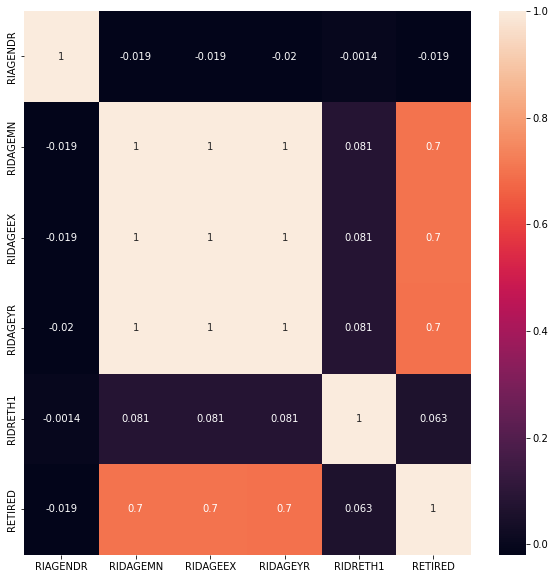

In [437]:
corrmat=train.corr()         #Correlation matrix
features=corrmat.index
plt.figure(figsize=(10,10))
g=sns.heatmap(train[features].corr(),annot=True )

We see that RIDAGEMN,RIDAGEEX and RIDAGEYR are highly correlated which makes sense because RIDAGEMN=RIDAGEYR*12 and RIDAGEEX=RDIDAGEMN + a constant(mostly 1). So we will remove two of these and try again.

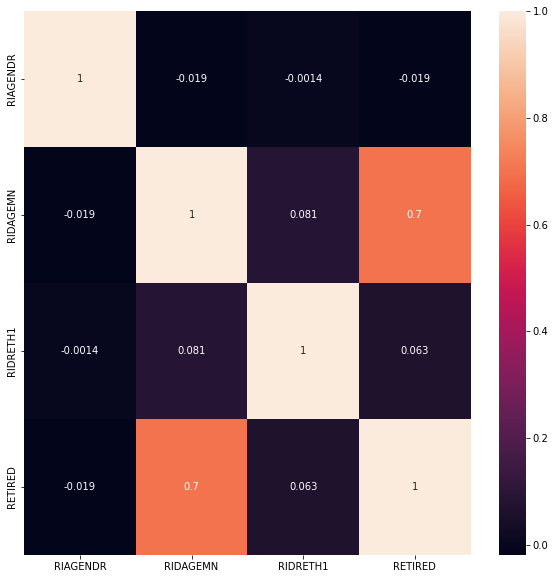

In [438]:
train=train.drop(['RIDAGEEX','RIDAGEYR'],axis=1)
corrmat=train.corr()
features=corrmat.index
plt.figure(figsize=(10,10))
g=sns.heatmap(train[features].corr(),annot=True )

We see that RETIRED is most correlated to RIDAGEMN

In [439]:
X=train.drop('RETIRED',axis=1)
y=train.RETIRED
X=pd.get_dummies(X,drop_first=True) #Encoding for HIGHEST_EDUCATION variable and dropping first to avoid Dummy variable trap

In [440]:
X.head()

RIAGENDR  RIDAGEMN  RIDRETH1  HIGHEST_EDUCATION_ELEMENTARY  \
1       2.0     132.0       4.0                             1   
2       1.0     189.0       4.0                             1   
3       2.0    1068.0       3.0                             0   
4       2.0     535.0       4.0                             0   
5       1.0     842.0       3.0                             0   

   HIGHEST_EDUCATION_HIGHSCHOOL  HIGHEST_EDUCATION_OTHERS  
1                             0                         0  
2                             0                         0  
3                             0                         1  
4                             0                         1  
5                             0                         0

In [441]:
X.shape

(8086, 6)

In [442]:
y.value_counts(normalize=True)

0.0    0.874722
1.0    0.125278
Name: RETIRED, dtype: float64

Since, our dataset is highly imbalanced with an abundance of class 0, we shall use F1 score as our validation metric

#### Modelling:
Why Random Forest?:  
Random Forests use bootstrap sampling and feature sampling and are not affected by multicollinearity that much since it is picking different set of features for different models and of course every model sees a different set of data points.
It provides higher accuracy through cross validation. Random forest classifier will handle the missing values and maintain the accuracy of a large proportion of data. If there are more trees (200), it won't allow over-fitting trees in the model which is a major concern because we have a very small dataset.

In [443]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state=42)
rf=RandomForestClassifier(n_estimators=200)         #Random Forest
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
print("\nF1 score Of RF For The Given Dataset : ", f1_score(y_test,y_pred))
print("\nClassification Report Of RF For The Given Dataset :\n ", classification_report(y_test,y_pred))
y_pred=rf.predict(X_train)
print("\nTraining Acuuracy :\n ", accuracy_score(y_train,y_pred))
y_pred=rf.predict(X_test)
print("\nValidation Acuuracy :\n ", accuracy_score(y_test,y_pred))



F1 score Of RF For The Given Dataset :  0.9987515605493134

Classification Report Of RF For The Given Dataset :
                precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2834
         1.0       1.00      1.00      1.00       401

    accuracy                           1.00      3235
   macro avg       1.00      1.00      1.00      3235
weighted avg       1.00      1.00      1.00      3235


Training Acuuracy :
  1.0

Validation Acuuracy :
  0.9996908809891808


We see that precision,recall and f1 scores are very high and since validation accuracy is so close yet lower than training accuracy, and are both very high, we ensure no overfitting or underfitting. We can now predict RETIRED null values:

In [444]:
test=test.drop(['RIDAGEEX','RIDAGEYR','RETIRED'],axis=1)
test['RETIRED']=rf.predict(pd.get_dummies(test,drop_first=True))

In [445]:
test.isnull().sum().sum()      #no nulls left

0

In [446]:
test.RETIRED.value_counts(),test.RETIRED.value_counts(normalize=True)

(0.0    2203
 1.0      59
 Name: RETIRED, dtype: int64,
 0.0    0.973917
 1.0    0.026083
 Name: RETIRED, dtype: float64)

In [448]:
filename = 'Impute_Retired_RF_model.sav'
joblib.dump(rf, filename)                     #Saved model file in submission

['Impute_Retired_RF_model.sav']

In [449]:
test.to_csv('Imputed_Retired.csv')               #Please find the same in my submission

# Exercise 2: Model Building
Please complete the following exercise in the same file as the other exercises, using comments in your
code to explain your reasoning.  
An auto-insurance company is revamping its pricing model. The analyst developing the new price model
believes that the best approach is to develop 2 models: one for customers who are likely to file an
insurance claim within the first year of their contract and another one for all other customers. The
analyst has prepared a clean dataset consisting of 10,000 customers and 10 engineered features which
capture driving behavior. The data has already been preprocessed for you (i.e., no missing data, no
outliers, data is scaled, no correlated features, and the classes are fairly balanced).
The data is contained in claim_prediction.csv , where CLAIM = 1 means the customer filed a claim in the
first year and CLAIM = 0 means the customer did not.  
Develop a model to predict if customers will file a claim in their first year based on their driving
behavior.  
In addition to submitting your code, use comments to explain the decisions you made and how well you
expect this model to perform on new data from a similar customer pool (and why).  
Note that you are being evaluated on your model building and validation workflow, rather than on the
complexity of your solution.  

##### Exploring Data

In [111]:
claim=pd.read_csv('claim_prediction.csv')
print("Database has {} observations (customers) and {} columns (attributes).".format(claim.shape[0],claim.shape[1]))
print("\nMissing values in each column:\n{}".format(claim.isnull().sum()*100/claim.shape[0]))
print("\nData Types:\n{}".format(claim.dtypes))

Database has 10000 observations (customers) and 11 columns (attributes).

Missing values in each column:
EADDC    0.0
EAFXA    0.0
FDDBC    0.0
AFDDA    0.0
AXCXA    0.0
EXCCE    0.0
FBXFC    0.0
DFFEC    0.0
CEXAE    0.0
BBADX    0.0
CLAIM    0.0
dtype: float64

Data Types:
EADDC    float64
EAFXA    float64
FDDBC    float64
AFDDA    float64
AXCXA    float64
EXCCE    float64
FBXFC    float64
DFFEC    float64
CEXAE    float64
BBADX    float64
CLAIM      int64
dtype: object


In [139]:
claim.head()

EADDC     EAFXA     FDDBC     AFDDA     AXCXA     EXCCE     FBXFC  \
0 -0.193513  0.021062 -0.870351  4.314903 -4.260162 -1.259531  0.175603   
1  2.667844 -3.195978  2.718651 -0.885312  2.964261  2.161336  2.008505   
2  2.280602  0.048539 -2.179863 -0.380866 -1.212960  2.097278  5.131315   
3  0.592376 -1.590548  2.329976 -1.416489  1.743390  3.040990  2.371740   
4  1.236896 -0.656180 -0.381064 -2.332379  0.660684  2.055621  0.478162   

      DFFEC     CEXAE     BBADX  CLAIM  
0 -0.942903  2.333260  4.678712      0  
1 -0.296360 -0.610780 -2.545978      1  
2 -1.250050  2.362880  2.207307      0  
3 -0.190549  0.890761 -2.671923      0  
4 -0.269513  2.614886 -3.655301      0

In [140]:
n_unique = claim.nunique()
print("Number of unique values:\n{}".format(n_unique))

Number of unique values:
EADDC    10000
EAFXA    10000
FDDBC    10000
AFDDA    10000
AXCXA    10000
EXCCE    10000
FBXFC    10000
DFFEC    10000
CEXAE    10000
BBADX    10000
CLAIM        2
dtype: int64


In [141]:
def boxes(x,data,h=None,r=30):        #univariate analysis
    fig, ax = plt.subplots(figsize=(12,1))
    box = sns.boxplot(x=x, hue=h, data=data)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()


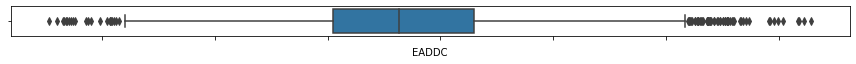

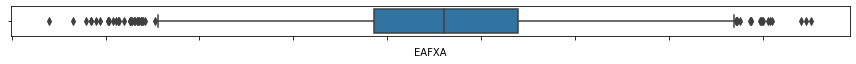

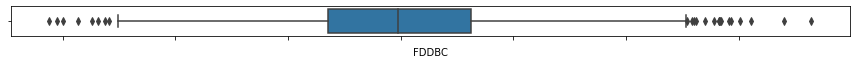

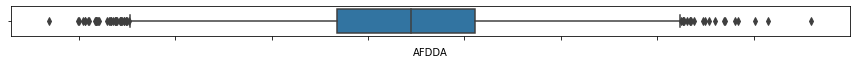

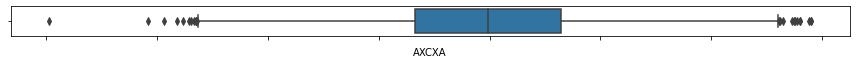

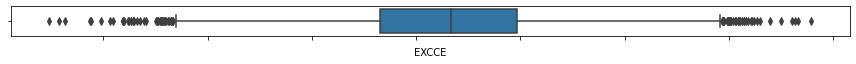

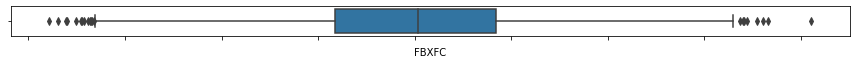

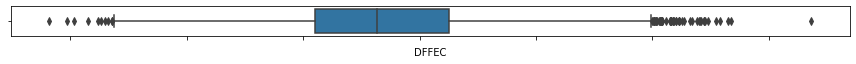

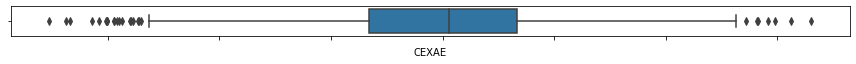

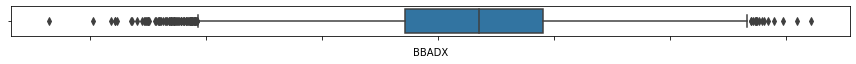

In [142]:
for col in claim.drop('CLAIM',axis=1).columns:
    boxes(col,claim)

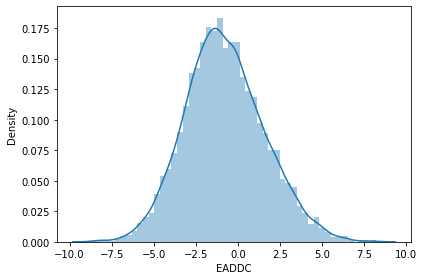

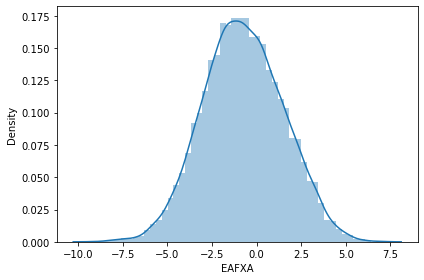

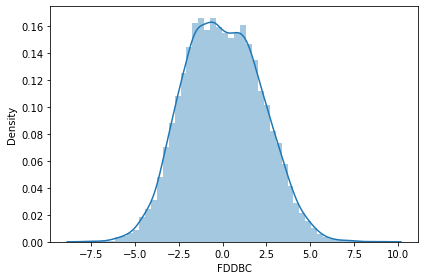

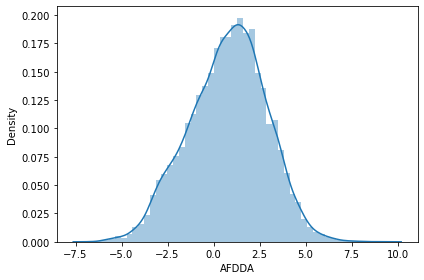

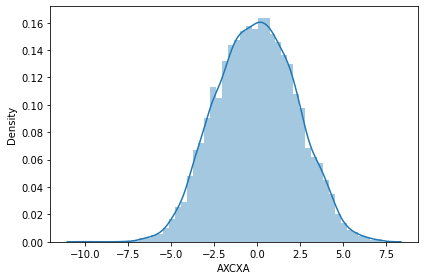

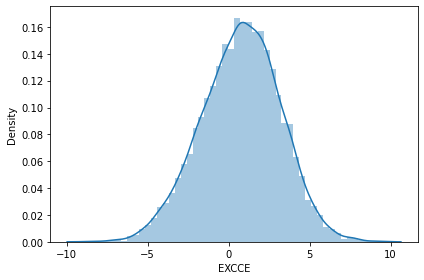

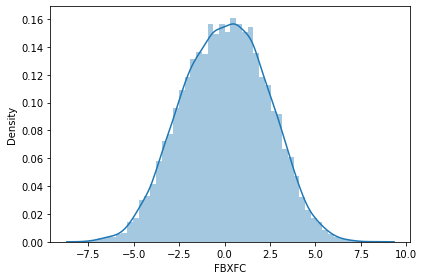

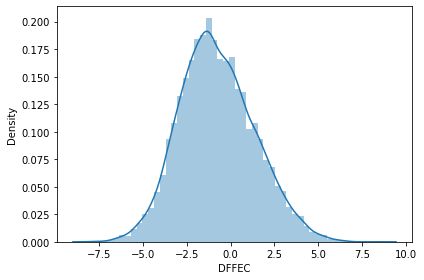

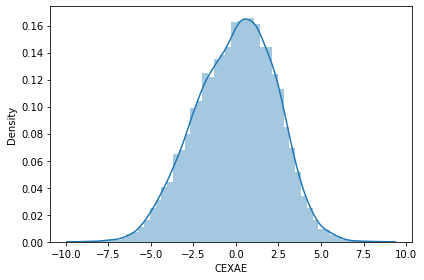

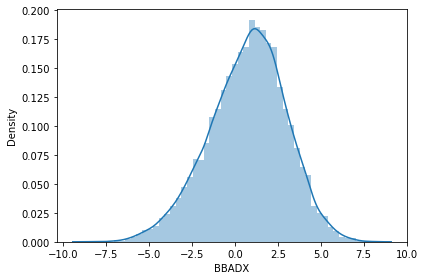

In [143]:
var=claim.drop('CLAIM',axis=1)
for col in var.columns:
    sns.distplot(var[col])
    plt.tight_layout()
    plt.show()

***All variables are more or less normally distributed with some outliers. Let's explore further:***

In [144]:
outliers = []
def detect_outliers_zscore(data):
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    # print(mean, std)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers                                         
for col in var.columns:
    sample_outliers = detect_outliers_zscore(var[col])
    print("No. of  Outliers from Z-scores method in"+col+": ", len(sample_outliers))

No. of  Outliers from Z-scores method inEADDC:  37
No. of  Outliers from Z-scores method inEAFXA:  62
No. of  Outliers from Z-scores method inFDDBC:  80
No. of  Outliers from Z-scores method inAFDDA:  104
No. of  Outliers from Z-scores method inAXCXA:  115
No. of  Outliers from Z-scores method inEXCCE:  143
No. of  Outliers from Z-scores method inFBXFC:  152
No. of  Outliers from Z-scores method inDFFEC:  172
No. of  Outliers from Z-scores method inCEXAE:  193
No. of  Outliers from Z-scores method inBBADX:  217


There are not many outliers and since I'm not familiar with the origins of data and the separate variable and their meanings, I'll have to keep them untreated because they may contain some useful information.

Bivariate Analysis:

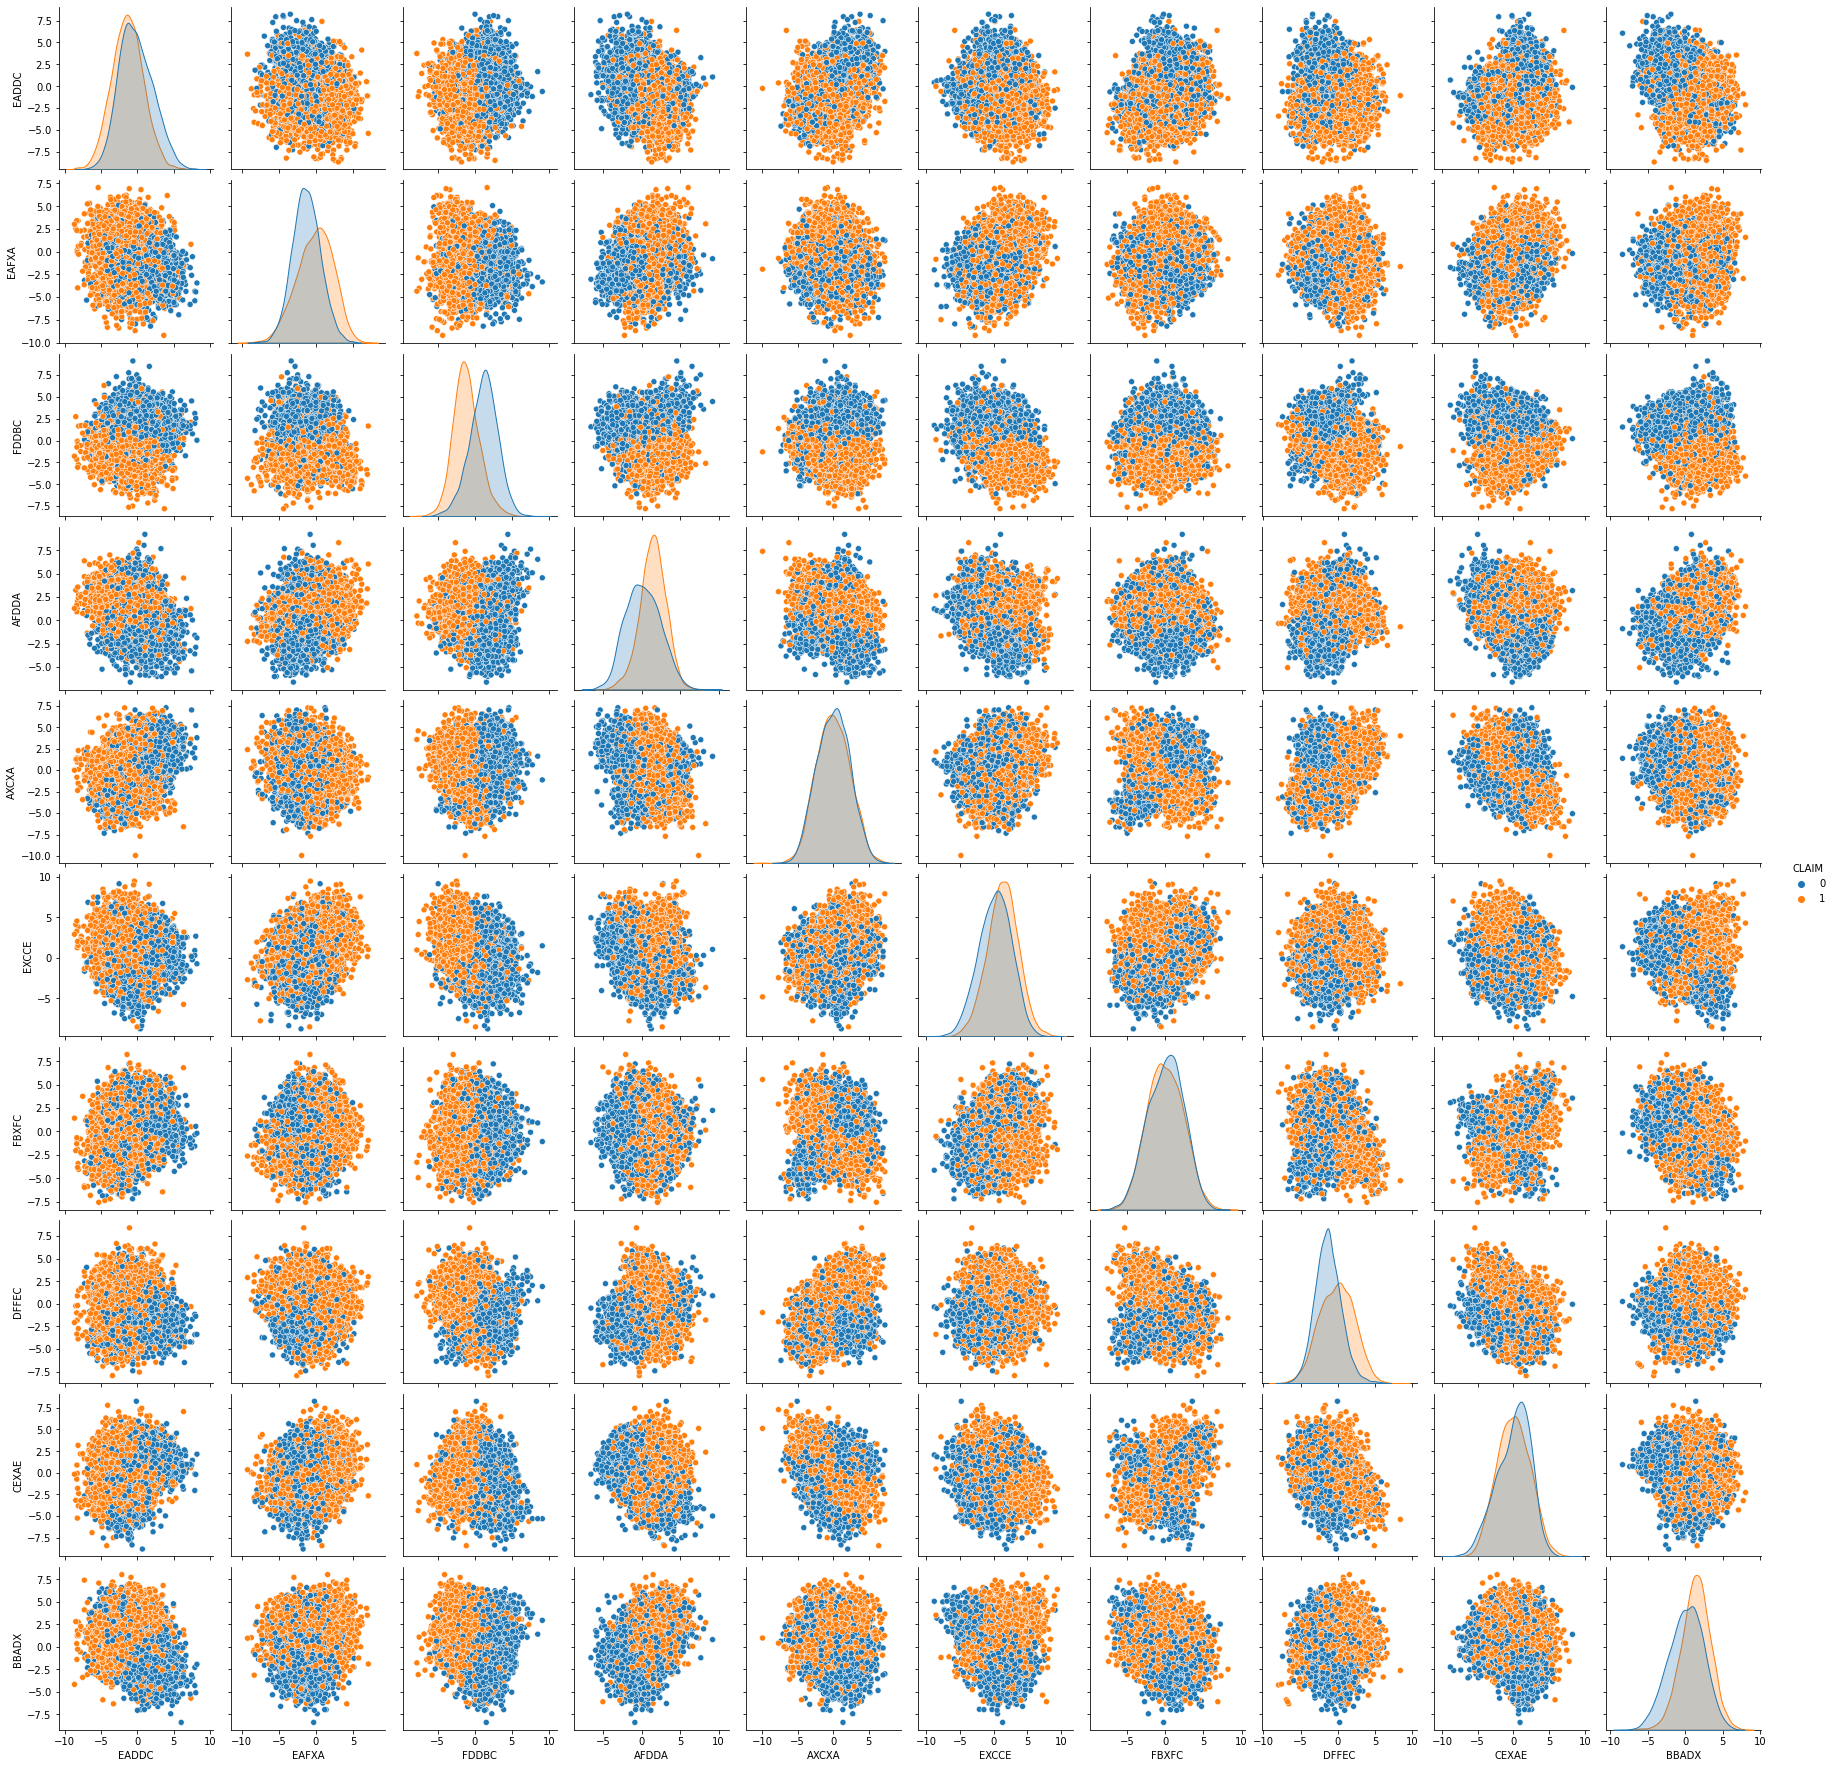

In [145]:
sns.pairplot(claim,hue='CLAIM')
plt.show()

*Insights:*  
No clear correlation present between predictors, i.e. no multicollinearity present but we'll verify more ahead   
EAFXA with higher values tend to have Claim as 1  
FDDBC with lower values tend to have Claim as 1  
AFDDA with lower values tend to have Claim as 1  
DFFEC with higher values tend to have Claim as 1  
BBADX with higher values tend to have Claim as 1  

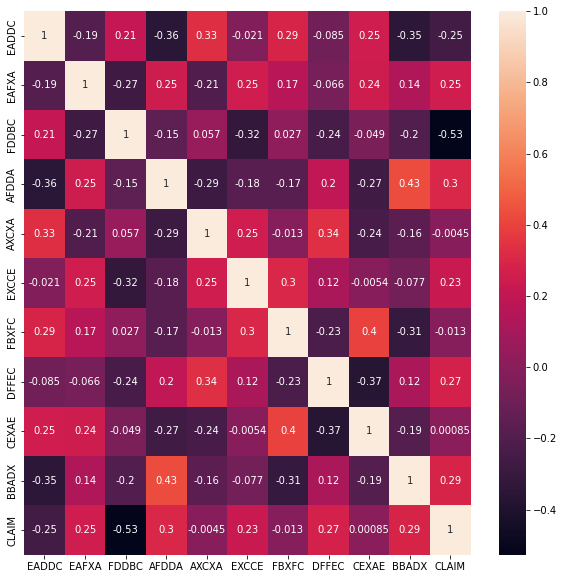

In [146]:
corrmat=claim.corr()                #Correlation coefficient
features=corrmat.index
plt.figure(figsize=(10,10))
g=sns.heatmap(claim[features].corr(),annot=True )

***FDDBC is the most correlated (negatively) variable to CLAIM***

In [150]:
X=claim.drop('CLAIM',axis=1)
y=claim.CLAIM
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state=42,stratify=y)

[0.07333901 0.08732951 0.20075729 0.10905886 0.0761876  0.08892256
 0.08111155 0.11416142 0.07525906 0.09387315]


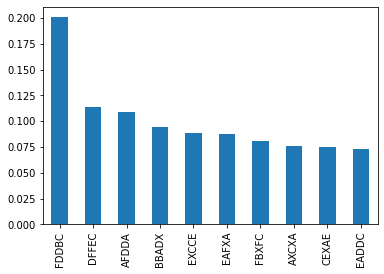

In [151]:
from sklearn.ensemble import ExtraTreesClassifier   #Feature Importance

feat_imp=ExtraTreesClassifier()
feat_imp.fit(X,y)
print(feat_imp.feature_importances_)
importances=pd.Series(feat_imp.feature_importances_,index=X.columns)
importances.nlargest(10).plot(kind='bar')
plt.show()

***As expected, FDDBC came out to be the most important Feature. (Since it was the highest correlated)***

In [154]:
#Checking for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
vif_data

feature       VIF
0   EADDC  1.622664
1   EAFXA  1.216612
2   FDDBC  1.352756
3   AFDDA  1.610045
4   AXCXA  1.622341
5   EXCCE  1.487018
6   FBXFC  1.550230
7   DFFEC  1.420185
8   CEXAE  1.645014
9   BBADX  1.509419

*No need to remove any variable as VIF is quite low (<5). No Multicollinearity detected. We did so because we will try to fit models in the next step.*

In [156]:
y.value_counts(normalize=True)    

0    0.5052
1    0.4948
Name: CLAIM, dtype: float64

 *Since our data is pretty much balanced, we'll look at Accuracy as our validation metric*  
 *Also since our data is already scaled as per the Exercise, no need to scale it further for KNN or LR models*

#### Model Selection:

***First, we will try out Machine Learning Models:***

In [159]:
def give_me_best(X_train,y_train,X_test,y_test,seed=42):
    train_acc=[]
    test_acc=[]
    model=[]
    
    print('Training LR\n')
    lr=LogisticRegression(max_iter=10000,random_state=seed)
    lr.fit(X_train, y_train)
    y_pred_train = lr.predict(X_train)
    train_acc.append(accuracy_score(y_train,y_pred_train))
    y_pred_test = lr.predict(X_test)
    test_acc.append(accuracy_score(y_test,y_pred_test))
    model.append(lr)
    print('Logistic Regression Done!\n')
    
    print('Training SVC\n')
    svc = SVC(random_state = seed)
    svc.fit(X_train,y_train)
    y_pred_train = svc.predict(X_train)
    train_acc.append(accuracy_score(y_train,y_pred_train))
    y_pred_test = svc.predict(X_test)
    test_acc.append(accuracy_score(y_test,y_pred_test))
    model.append(svc)
    print('Support Vector Machines Done!\n')
    
    print('\nTraining RF\n')
    rf=RandomForestClassifier(n_estimators=500,random_state=seed)
    rf.fit(X_train,y_train)
    y_pred_train = rf.predict(X_train)
    train_acc.append(accuracy_score(y_train,y_pred_train))
    y_pred_test = rf.predict(X_test)
    test_acc.append(accuracy_score(y_test,y_pred_test))
    model.append(rf)
    print('Random Forests Done!\n')
    
    print('\nTraining KNN\n')
    knn_r_acc = []
    for i in range(1,30,1):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train,y_train)
        y_pred=knn.predict(X_test)
        ac=accuracy_score(y_test,y_pred)
        knn_r_acc.append((i, ac))
    df = pd.DataFrame(knn_r_acc, columns=['K','Validation Accuracy'])
    plt.figure()
    sns.lineplot(df['K'],df['Validation Accuracy'])
    plt.show()
    opt_k=df[df['Validation Accuracy']==df['Validation Accuracy'].max()]['K']
    if type(opt_k)!='pandas.core.series.Series':
        opt_k=opt_k.tolist()[0]
    print('Optimum K:'+str(opt_k)+'\n')
    print('Retraining with K='+str(opt_k)+'\n')
    knn = KNeighborsClassifier(n_neighbors=opt_k)
    knn.fit(X_train,y_train)
    y_pred_train = knn.predict(X_train)
    train_acc.append(accuracy_score(y_train,y_pred_train))
    y_pred_test = knn.predict(X_test)
    test_acc.append(accuracy_score(y_test,y_pred_test))
    model.append(knn)
    print('K Nearest Neighbours Done!\n')
    
    print('\nTraining XGBoost\n')
    xg=XGBClassifier(n_estimators=500,use_label_encoder=False,random_state=seed)
    xg.fit(X_train,y_train)
    y_pred_train = xg.predict(X_train)
    train_acc.append(accuracy_score(y_train,y_pred_train))
    y_pred_test = xg.predict(X_test)
    test_acc.append(accuracy_score(y_test,y_pred_test))
    model.append(xg)
    print('XG Boost Classifier Done!\n')
    
    print('\nTraining LGBM\n')
    lgb = LGBMClassifier(n_estimators=500,random_state=seed,learning_rate=0.001)
    lgb.fit(X_train,y_train)
    y_pred_train = lgb.predict(X_train)
    train_acc.append(accuracy_score(y_train,y_pred_train))
    y_pred_test = lgb.predict(X_test)
    test_acc.append(accuracy_score(y_test,y_pred_test))
    model.append(lgb)
    print('Light GBM Classifier Done!\n')
    
    print('Highest Validation Accuracy is '+str(pd.Series(test_acc).max())+' by following model:\n')
    temp=pd.DataFrame([model,train_acc,test_acc],index=['Model','Train_Accuracy','Validation_Accuracy']).T
    print(temp[temp.Validation_Accuracy==temp.Validation_Accuracy.max()]['Model'])
      
    return temp

Training LR

Logistic Regression Done!

Training SVC

Support Vector Machines Done!


Training RF

Random Forests Done!


Training KNN



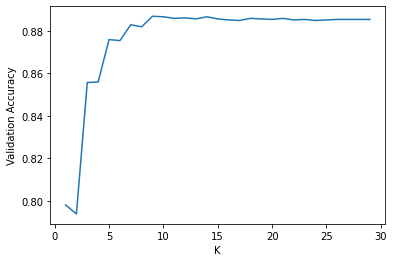

Optimum K:9

Retraining with K=9

K Nearest Neighbours Done!


Training XGBoost

[18:36:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XG Boost Classifier Done!


Training LGBM

Light GBM Classifier Done!

Highest Validation Accuracy is 0.88775 by following model:

1    SVC(random_state=42)
Name: Model, dtype: object


In [160]:
best=give_me_best(X_train,y_train,X_test,y_test)

In [161]:
best

Model Train_Accuracy  \
0  LogisticRegression(max_iter=10000, random_stat...       0.823333   
1                               SVC(random_state=42)       0.888167   
2  (DecisionTreeClassifier(max_features='auto', r...            1.0   
3                KNeighborsClassifier(n_neighbors=9)       0.887667   
4  XGBClassifier(base_score=0.5, booster='gbtree'...            1.0   
5  LGBMClassifier(learning_rate=0.001, n_estimato...       0.863167   

  Validation_Accuracy  
0             0.81475  
1             0.88775  
2              0.8695  
3               0.887  
4               0.862  
5              0.8325

Best Model: Support Vector Machines  
There's good competition between KNN and SVC but since SVC has greater training accuracy and minutely higher validation accuracy, we shall go with SVC. 
RF and XGB overfits data while LR and LGBM have lower accuracy.  
Now, let's tune hyperparameters of SVC to try to improve upon it.

In [189]:
param_grid = {'C': [0.1,0.25,0.5,0.75,1,2,5,10,100], 
              'gamma': [1,0.5,0.1,0.05,0.025,0.01,0.001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(random_state=42), param_grid, cv=5, refit = True,scoring='accuracy' ,verbose = 1)
grid.fit(X_train,y_train)

# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
print("\nTraining Acuuracy :\n ", accuracy_score(y_train,grid.predict(X_train)))  
print("\nValidation Acuuracy :\n ", accuracy_score(y_test,grid_predictions))
# print classification report
print(classification_report(y_test, grid_predictions))

Fitting 5 folds for each of 63 candidates, totalling 315 fits
{'C': 2, 'gamma': 0.05, 'kernel': 'rbf'}
SVC(C=2, gamma=0.05, random_state=42)

Training Acuuracy :
  0.9018333333333334

Validation Acuuracy :
  0.886
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2021
           1       0.89      0.88      0.88      1979

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



Tuning does not help much as validation accuracy does not increase but training accuracy does. This basically suggests that model is trying to overfit.   
Let's try combining top 3 models together:  

In [260]:
#Top 3 models according to validation accuracy
svc_1=best.Model[1]
rf_2=best.Model[2]
knn_3=best.Model[3]

evc=VotingClassifier(estimators=[('svc',svc_1),
                                 ('rf',rf_2),('knn',knn_3)],voting='hard')
evc.fit(X_train, y_train)
print("\nTraining Acuuracy :\n ", accuracy_score(y_train.values,evc.predict(X_train)))  
print("\nValidation Acuuracy :\n ", accuracy_score(y_test,evc.predict(X_test)))


Training Acuuracy :
  0.8918333333333334

Validation Acuuracy :
  0.8855


We shall now try a Deep Learning model and compare results before finalizing our model selection

In [212]:
def create_model(neurons,activation,optimizer):
    model = Sequential()
    model.add(Dense(neurons, input_dim=10, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
model = KerasClassifier(build_fn=create_model, verbose=0)
batch_size = [100, 200 ,500]
epochs = [20, 100, 150]
neurons = [20, 50 ,75]
activation = ['softmax', 'relu', 'tanh']
optimizer = ['SGD', 'RMSprop','Adam']

param_grid = dict(batch_size=batch_size, epochs=epochs,neurons=neurons,
                 activation=activation,optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3,verbose=2)
grid_result = grid.fit(X_train,y_train)

***Hyperparameter tuning:***  
*Tuning Batch Size, Epochs, No. of Neurons, Activation Functions, Optimizers*  

In [201]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.883667 using {'activation': 'tanh', 'batch_size': 200, 'epochs': 100, 'neurons': 75, 'optimizer': 'Adam'}
0.708333 (0.046462) with: {'activation': 'softmax', 'batch_size': 100, 'epochs': 20, 'neurons': 20, 'optimizer': 'SGD'}
0.869833 (0.005169) with: {'activation': 'softmax', 'batch_size': 100, 'epochs': 20, 'neurons': 20, 'optimizer': 'RMSprop'}
0.869167 (0.004028) with: {'activation': 'softmax', 'batch_size': 100, 'epochs': 20, 'neurons': 20, 'optimizer': 'Adam'}
0.653333 (0.044265) with: {'activation': 'softmax', 'batch_size': 100, 'epochs': 20, 'neurons': 50, 'optimizer': 'SGD'}
0.871500 (0.008495) with: {'activation': 'softmax', 'batch_size': 100, 'epochs': 20, 'neurons': 50, 'optimizer': 'RMSprop'}
0.871667 (0.007364) with: {'activation': 'softmax', 'batch_size': 100, 'epochs': 20, 'neurons': 50, 'optimizer': 'Adam'}
0.643833 (0.048464) with: {'activation': 'softmax', 'batch_size': 100, 'epochs': 20, 'neurons': 75, 'optimizer': 'SGD'}
0.873000 (0.005788) with: {'activati

 *Now we'll fit the best model, add a Dropout layer and tune learning rate, dropout rate and weight_constraint*

In [237]:
def tune_more(learn_rate,dropout_rate, weight_constraint):
    model = Sequential()
    model.add(Dense(75, input_dim=10, activation='tanh',kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    optimizer=Adam(learning_rate=learn_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    return model
model = KerasClassifier(build_fn=tune_more, verbose=0,epochs=100, batch_size=200)
model._estimator_type='classifier'
learn_rate = [0.00001,0.0001,0.001,0.01]
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

param_grid = dict(learn_rate=learn_rate,dropout_rate=dropout_rate, weight_constraint=weight_constraint)

grid_1 = GridSearchCV(estimator=model, param_grid=param_grid,n_jobs=-1, cv=3,verbose=2)
grid_1_result = grid_1.fit(X_train,y_train)


Fitting 3 folds for each of 200 candidates, totalling 600 fits


In [238]:
print("Best: %f using %s" % (grid_1_result.best_score_, grid_1_result.best_params_))
means = grid_1_result.cv_results_['mean_test_score']
stds = grid_1_result.cv_results_['std_test_score']
params = grid_1_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.883500 using {'dropout_rate': 0.1, 'learn_rate': 0.001, 'weight_constraint': 4}
0.757000 (0.011113) with: {'dropout_rate': 0.0, 'learn_rate': 1e-05, 'weight_constraint': 1}
0.770500 (0.023252) with: {'dropout_rate': 0.0, 'learn_rate': 1e-05, 'weight_constraint': 2}
0.771167 (0.005720) with: {'dropout_rate': 0.0, 'learn_rate': 1e-05, 'weight_constraint': 3}
0.743833 (0.045075) with: {'dropout_rate': 0.0, 'learn_rate': 1e-05, 'weight_constraint': 4}
0.736500 (0.026618) with: {'dropout_rate': 0.0, 'learn_rate': 1e-05, 'weight_constraint': 5}
0.852333 (0.004836) with: {'dropout_rate': 0.0, 'learn_rate': 0.0001, 'weight_constraint': 1}
0.850833 (0.004365) with: {'dropout_rate': 0.0, 'learn_rate': 0.0001, 'weight_constraint': 2}
0.850167 (0.006329) with: {'dropout_rate': 0.0, 'learn_rate': 0.0001, 'weight_constraint': 3}
0.854000 (0.003742) with: {'dropout_rate': 0.0, 'learn_rate': 0.0001, 'weight_constraint': 4}
0.852667 (0.005072) with: {'dropout_rate': 0.0, 'learn_rate': 0.0001, '

*Predicting using best model*

In [245]:
nn=grid_1_result.best_estimator_
nn._estimator_type='classifier'

In [259]:
y_pred=nn.predict(X_test).flatten()
print("\nF1 score Of RF For The Given Dataset : ", f1_score(y_test,y_pred))
print("\nClassification Report Of RF For The Given Dataset :\n ", classification_report(y_test,y_pred))
y_pred=nn.predict(X_train)
print("\nTraining Acuuracy :\n ", accuracy_score(y_train,y_pred))
y_pred=nn.predict(X_test)
print("\nValidation Acuuracy :\n ", accuracy_score(y_test,y_pred))


F1 score Of RF For The Given Dataset :  0.8805478062389045

Classification Report Of RF For The Given Dataset :
                precision    recall  f1-score   support

           0       0.88      0.89      0.88      2021
           1       0.88      0.88      0.88      1979

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000


Training Acuuracy :
  0.8881666666666667

Validation Acuuracy :
  0.88225


***Overall Summary of Model Selection***  
Even though we saw increases in training accuracy, overall comparing validation accuracy, we see the best model is SVC(random_state=42).  
Final Model:SVC   
Let's predict and save!  

In [261]:
svc=best.Model[1]
y_pred=svc.predict(X_test).flatten()
print("\nF1 score Of RF For The Given Dataset : ", f1_score(y_test,y_pred))
print("\nClassification Report Of RF For The Given Dataset :\n ", classification_report(y_test,y_pred))
y_pred=svc.predict(X_train)
print("\nTraining Acuuracy :\n ", accuracy_score(y_train,y_pred))
y_pred=svc.predict(X_test)
print("\nValidation Acuuracy :\n ", accuracy_score(y_test,y_pred))


F1 score Of RF For The Given Dataset :  0.8865301996461966

Classification Report Of RF For The Given Dataset :
                precision    recall  f1-score   support

           0       0.89      0.89      0.89      2021
           1       0.89      0.89      0.89      1979

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000


Training Acuuracy :
  0.8881666666666667

Validation Acuuracy :
  0.88775


In [262]:
filename = 'finalized_claim_model.sav'
joblib.dump(svc, filename)                     #Saved model file in submission

['finalized_claim_model.sav']

In [265]:
X_test['Predictions']=y_pred
X_test['Actual']=y_test
X_test.to_csv('Claim_Predicted.csv')      #Please find this file in my submission

Since our model has fit well without overfitting/underfitting, we can safely say that on a new data from a similar customer pool, it will perform with approximately 88.78% accuracy.

# Exercise 3: Model Evaluation

Please respond to the following short answer questions, numbered in the same file as other exercises.
### 1. What is one way to determine the number of clusters in K-Means clustering? How would you estimate the efficacy, or quality, of the K-means clustering results?

#### Answer:
#### How the K-means algorithm works:
To process the learning data, the K-means algorithm starts with a group of randomly selected centroids, which are used as the beginning points for every cluster, and then performs iterative calculations to optimize the positions of the centroids. It halts creating and optimizing clusters when either:  
The centroids have stabilized or--  
there is no change in their values because the clustering has been successful or the defined number of iterations has been achieved.



To determine the number of clusters or K, we can use a :  
###### Scree Plot  
Here we take a certain range of values for K and perform K-means clustering for all of them. For each value, we store average distance to centroid (centres of clusters) across all data points. Then we plot on X axis the values of K and on y axis the average distances. This plot is shaped like an elbow, hence the method is also called The Elbow Method. As the number of clusters increase, the variance (within-cluster sum of squares of distances) decreases. The elbow point is the optimum K value where the most parsimonious balance between minimizing the number of clusters and minimizing the variance within each cluster is reached. It's called the elbow point because here the aforementioned average distance drops significantly and suddenly. That optimum K value is number of clusters we use to retrain our best fit K means model.

To determine the efficacy of our clusters, we can use:  
#### Silhouette analysis
The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette coefficient ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters. 
Calculation:
Compute the average distance from all data points in the same cluster (ai).
Compute the average distance from all data points in the closest cluster (bi).
Calculate the coefficient for a particular data point:  
S(i)=[b(i)-a(i)]/max{b(i),a(i)}  
Average Silhouette=mean(S(i)) 

Interpreting the coefficient(avg silhouette) :  
If it is 0:the sample is very close to the neighboring clusters.  
It it is 1: the sample is far away from the neighboring clusters.  
It it is -1: the sample is assigned to the wrong clusters.   
Hence ideal value is close to 1.

***For example of the above using real world data, please find my Banking Customer Segmentation project below:    
https://github.com/VarishuPant99/Bank_Customer_Segmentation/blob/master/K-Means_Cluster_Analysis.ipynb***

### 2. Your linear regression model is suffering from low bias and high variance. What steps can you take to improve your model?

Bias is the difference between the average prediction of our model and the correct value which we are trying to predict. Model with high bias pays very little attention to the training data and oversimplifies the model. It always leads to high error on training and test data.  
Variance is the variability of model prediction for a given data point or a value which tells us spread of our data. Model with high variance pays a lot of attention to training data and does not generalize on the data which it hasn’t seen before. As a result, such models perform very well on training data but has high error rates on test data.  
If our model has large number of parameters then it’s going to have high variance and low bias.In other words, we have the problem of overfitting. Multicollinearity can also lead to overfitting and high variance.

*Steps to reduce overfitting to improve model:*-  

1.Reduce number of features to reduce complexity  
2.Gather more observations making the data dense and difficult to overfit  
3.Use regularization :  
Ridge Regression (L2 regularization) helps to balance bias-variance tradeoff. Keeping in mind that estimated coefficients explode when a model overfits data, a desired cost function should be able to balance between fit of data and magnitude of coefficients. Ridge regression does this by introducing a penalty term (λ times sum of squares of estimated coefficients or ∑β sqaured) to the cost. Here λ is a tuning parameter that helps us balance the extent of the penalty. Higher values of the coefficients represent a model with greater flexibility. To penalize this flexibility we use λ. When the value of λ tends to zero, the L2 regularization equation becomes the loss function of the linear regression model. The penalty term will have no effect. This means that if the value of λ is minimum, the model can be called a simple linear regression model.
Conversely, when the λ value tends to infinity, the effect of the shrinkage penalty increases. As a result, the coefficient estimates of the ridge regression will approach zero. This underlines the importance of choosing a good value for λ. To choose best value of λ, we can use GridSearchCV.Ridge regression is a potential solution to handle multicollinearity too.
Collinearity is a condition in which there are two features in data that are heavily correlated to each other. Ridge regression adds an amount of bias to the regression estimates to reduce errors. It gives smaller to weights to variables that are correlated to each other hence reducing multicollinearity and in turn reducing variance.

The predictors of least importance refer to predictors that bear no telling influence on the predictive power of the model. They may also be predictors that do not accurately describe the properties of data, such as noise.
Ridge regression prefers to add small weights to all variables. If, however we choose to reduce complexity by feature selection, we can use Lasso regression which removes some variables by giving them 0 weights. This is because Lasso (L1 regularization) adds λ times the absolute values of the regression coefficients (∣β∣) as the penalty to cost function.The shrinking coefficients minimizes the bias and improves the variance of models. A context that favors the use of lasso is, when we have a small dataset with more number of features.The tuning parameter λ controls the shrinkage. From the equation, when λ is zero, the equation is reduced to the linear regression loss function equation. The greater the value of λ, the greater the reduction of the coefficients will be towards zero.
  

### 3. Below is a scenario for training error (TE) and validation error (VE) for several iterations of a machine learning model. Which model would you choose, and why?

| Model | TE | VE |
| --- | --- | --- |
| 1 | 105 | 90 |
| 2 | 200 | 85 |
| 3 | 250 | 96 |
| 4 | 105 | 85 |
| 5 | 300 | 100 |



#### Answer: We'll choose Model 4 because it has the lowest TE and VE meaning highest training and validation accuracy

### 4. 
You have built a model for a binary classification problem. 
The trained model was applied to the
validation dataset and produced the results documented in the following confusion matrix.

In [4]:
pd.DataFrame([[97,48],[6,112]],index=['Actual N','Actual Y'],columns=['Predicted N','Predicted Y'])

Predicted N  Predicted Y
Actual N           97           48
Actual Y            6          112

#### a. Calculate Recall, Precision and F-1 score.

#### Answer :
Since Recall = TruePositives / (TruePositives + FalseNegatives)

In [6]:
recall=112/(112+6)
print('Recall:',recall)

Recall: 0.9491525423728814


#### b. If your classifier model is attempting to predict cancer in patients. Which type of error should you focus on for this type of problem? Which evaluation metric would you choose and why?


#### Answer:
We would focus on Type 2(rejecting Alternative hypothesis falsely) error because if the model predicts no cancer when cancer is present, it would mean fatally risking the patient's health. Therefore we need to make sure Type 2 error is very low.  
We would focus on Recall metric because Recall takes into account False Negatives. With the same reasoning as for choosing Type 2 error, we can say False Negatives should be our focus and we should try to decrease false negatives, hence increasing Recall.
Also, data like cancer prediction are usually highly imbalanced with majority class being 0 (no cancer). In such a case, accuracy metric won't be a good representative for the model.

#### c. If your classifier model is attempting to determine whether or not to recommend a YouTube video. Which type of error should you focus on for this type of problem? Which evaluation metric would you choose and why?

From Youtube's perspective, giving a bad recommendation could break the repetitive watch cycle of the consumer. Since Youtube's revenue is based on watch time rather than views, we'd want to try and retain customer on site for as long as possible. Also, knowing that at any particular moment, there are millions of videos for a particular category, we can assume that by the customer's previous watch history, or similar customers' watch patterns, there would be lots of potential videos we can recommend. That being said, the recommended section can only be so big, therefore we only need the cream of the crop, the best of the best videos, meaning that false positives are a big issue. We would only want to recommend those videos that should truly be recommended, that is true positives. Therefore:  
We would focus on Type 1 error(Rejecting null hypothesis falsely) because we want to make sure that only recommendation worthy videos get predicted as 1(recommended).  
Following the same reasoning, we would focus on the metric Precision. Since:
 Precision = TP / (TP + FP)  
We can focus on increasing precision by minimizing false positives.

# Exercise 4: Anomaly Detection
Please complete the following exercise in the same file as the other exercises, using comments in your
code to explain your reasoning.
An oil and gas company with several offshore platforms is experimenting with anomaly detection on one
of its platforms. An analyst has provided you with sample data for the pilot platform
( anomaly_detection.csv ). The data is a time series dataset, consisting of average daily readings from 5
sensors between 01/01/2016 and 12/30/2016. You can assume that data preprocessing (filling missing
values, scaling, etc) has been handled by the analyst. You can also assume that the daily readings are
independent and identically distributed.
The analyst has reviewed operation notes for the first 9 months (01/01/2016 to 09/30/2016) and
identified that there were issues on the platform between 02/14/2016 and 02/21/2016. The analyst did
not have time to review the final 3 months of data.
Use the first 9 months of data (01/01/2016 to 09/30/2016) to develop an anomaly detection model and
test it on the final 3 months of data (10/01/2016 to 12/30/2016). How many anomalous periods were
identified in the test period between 10/01/2016 and 12/30/2016? Only report anomalies that last
longer than 2 days. Additionally, if an anomaly lasts for longer than 14 days, we consider that behavior
to be the new normal, and we do not report it.
Hint: There are multiple potential approaches to solving this problem. One acceptable solution to this
problem is to train a PCA model on normal data. Given new data, risk can be computed as the difference
between the input data and reconstructed data, where reconstructed data is the result of compressing
and decompressing the input data using PCA.

In [450]:
anom=pd.read_csv('anomaly_detection.csv')
print("Database has {} observations (customers) and {} columns (attributes).".format(anom.shape[0],anom.shape[1]))
print("Database has {} observations (customers) and {} columns (attributes).".format(anom.shape[0],anom.shape[1]))
print("\nMissing values in each column:\n{}".format(anom.isnull().sum()*100/anom.shape[0]))
print("\nData TTypes:\n{}".format(anom.dtypes))

Database has 365 observations (customers) and 5 columns (attributes).
Database has 365 observations (customers) and 5 columns (attributes).

Missing values in each column:
CEACC    0.0
CCDEF    0.0
FAXAE    0.0
FBFFD    0.0
EDDAB    0.0
dtype: float64

Data TTypes:
CEACC    float64
CCDEF    float64
FAXAE    float64
FBFFD    float64
EDDAB    float64
dtype: object


#### Using PCA:

In [451]:
#Adding Date column
dates = pd.date_range(start='2016-01-01', periods=365, freq='d')   #Adding date column
anom['Date']=dates
#Tagging period with issues
anom['Issues']=np.where((anom['Date']>=pd.to_datetime('14/02/2016')) & (anom['Date']<=pd.to_datetime('21/02/2016')),1,0)

In [452]:
anom.shape

(365, 7)

In [453]:
#Removing issue period 
anom=anom[anom['Issues']==0]
print(anom.shape)
#Giving normal data to train
X_train=anom[anom.Date<=pd.to_datetime('09/30/2016')]
X_train=X_train.drop(['Date','Issues'],axis=1)
#Keeping last 3 months for testing:
X_test=anom[anom.Date>=pd.to_datetime('10/01/2016')]
X_test=X_test.drop(['Date','Issues'],axis=1)
X_train.shape,X_test.shape

(357, 7)


((266, 5), (91, 5))

Let's train PCA on X_train and for given test data, compute risk as the difference between the input data and reconstructed data, where reconstructed data is the result of compressing and decompressing the input data using PCA. Let's use Maximum of maximum method to find anomalies because even if we get more anomalies than in other methods, we'll filter them using the rules given in the question.

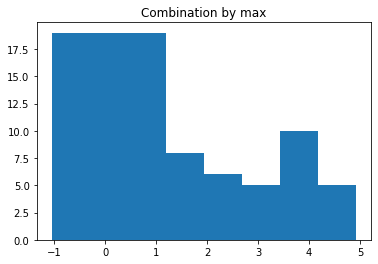

1    67
0    24
Name: y_by_maximization_cluster, dtype: int64

In [454]:
# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)
# Test a range of no. of pca components
n_clf = 5
k_list = [1,2,3,4,5,6,7,8,9,10]
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])
train_scores.shape
# Modeling
for i in range(n_clf):
    k = k_list[i]
    clf = PCA(n_components=k)
    clf.fit(X_train_norm)
    # Store the results in each column:
    train_scores[:, i] = clf.decision_scores_
    test_scores[:, i] = clf.decision_function(X_test_norm) 
    
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

# Combination by mom
y_by_maximization = maximization(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

df_test = pd.DataFrame(X_test)
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<0, 0, 1)
df_test['y_by_maximization_cluster'].value_counts()

In [455]:
filename = 'PCA_model.sav'    #Please find in my submission
joblib.dump(clf, filename)  

['PCA_model.sav']

We get 67 out of 91 values as anomalies  
Let's see the characteristics of the clusters:

In [456]:
df_test.groupby('y_by_maximization_cluster').mean()

CEACC     CCDEF     FAXAE     FBFFD     EDDAB  \
y_by_maximization_cluster                                                     
0                          9.720737  5.014938  0.308885  4.990075  8.816105   
1                          9.304299  4.027997 -0.898860  5.709053  9.658258   

                           y_by_maximization_score  
y_by_maximization_cluster                           
0                                        -0.587433  
1                                         1.821120

Clear distinction in FAXAE values present between clusters

***Applying filters:***   
Only report anomalies that last longer than 2 days. Additionally, if an anomaly lasts for longer than 14 days, we consider that behavior to be the new normal, and we do not report it.

In [457]:
dates = pd.date_range(start='2016-10-01', periods=91, freq='d')   #Adding date column
df_test['Dates']=dates
df_test['To_Report']=df_test.y_by_maximization_cluster.rolling(3).sum()   #Rolling sum of anomalies for a period of 2 days
df_test['Normalized_Again']=df_test.y_by_maximization_cluster.rolling(15).sum() #Rolling sum of anomalies for a period of 14 days
#Only consider anomalies that last longer than 2 days or has to_report as 2 and less than or equal to 14 days
df_test['True_Anomalies']=np.where((df_test['To_Report']==3) & (df_test['Normalized_Again']<=14),1,0)
df_test.True_Anomalies.value_counts()

0    64
1    27
Name: True_Anomalies, dtype: int64

In [458]:
#Script to check where an anomalous period starts and how many there are
s=df_test.To_Report.tolist()
c=0
for i in range(len(s)-1):
    if (s[i]>=2) and (s[i]<s[i+1]) and (s[i]<=14):
        c+=1
        print(i,s[i])
    
print(c)

9 2.0
31 2.0
45 2.0
57 2.0
4


*We detect 4 anomalous periods in our 3 month dataset starting at 8th,30th,44th and 56th row of df_test*  
***let's consider another approach***

In [459]:
df_test.iloc[8],df_test.iloc[31],df_test.iloc[44],df_test.iloc[56]       #Start points of anomalous periods

(CEACC                                    4.92378
 CCDEF                                   2.907209
 FAXAE                                   1.290741
 FBFFD                                   4.739916
 EDDAB                                   8.359005
 y_by_maximization_score                 0.025659
 y_by_maximization_cluster                      1
 Dates                        2016-10-09 00:00:00
 To_Report                                    1.0
 Normalized_Again                             NaN
 True_Anomalies                                 0
 Name: 282, dtype: object,
 CEACC                                   9.742074
 CCDEF                                   5.487597
 FAXAE                                   0.608378
 FBFFD                                   3.718403
 EDDAB                                   7.626001
 y_by_maximization_score                 0.244442
 y_by_maximization_cluster                      1
 Dates                        2016-11-01 00:00:00
 To_Report             

In [460]:
df_test.to_csv('Anomaly_Detection_Using_PCA.csv')

#### Using Isolation Forest:

In [367]:
del[anom,X_train,X_test,df_test]
# load the dataset
anom=pd.read_csv('anomaly_detection.csv')
#Adding Date column
dates = pd.date_range(start='2016-01-01', periods=365, freq='d')   #Adding date column
anom['Date']=dates
#Tagging period with issues
anom['Anomaly']=np.where((anom['Date']>=pd.to_datetime('14/02/2016')) & (anom['Date']<=pd.to_datetime('21/02/2016')),1,0)
X_train=anom[anom.Date<=pd.to_datetime('09/30/2016')]
y_train=X_train.Anomaly
X_train=X_train.drop(['Date','Anomaly'],axis=1)
X_test=anom[anom.Date>=pd.to_datetime('10/01/2016')]
y_test=X_test.Anomaly
X_test=X_test.drop(['Date','Anomaly'],axis=1)
print(X_train.shape, y_train.shape)
# identify outliers in the training dataset
iso = IsolationForest(n_estimators=5000,random_state=42)
yhat = iso.fit_predict(X_train)

(274, 5) (274,)


In [368]:
print('Isolation Forest Training Accuracy:',accuracy_score(y_train,np.where(yhat==-1,1,0)))
ypred = iso.fit_predict(X_test)
X_test['Anomaly_Pred']=np.where(ypred==-1,1,0)

Isolation Forest Training Accuracy: 0.8540145985401459


In [369]:
X_test.Anomaly_Pred.value_counts()  #26 anomalies

0    65
1    26
Name: Anomaly_Pred, dtype: int64

In [370]:
filename = 'Isolation_Forest_model.sav'    #Please find in my submission
joblib.dump(iso, filename)  

['Isolation_Forest_model.sav']

In [371]:
#Applying filters
dates = pd.date_range(start='2016-10-01', periods=91, freq='d')   #Adding date column
df_test=X_test.copy()
df_test['Dates']=dates
df_test['To_Report']=df_test.Anomaly_Pred.rolling(3).sum()   #Rolling sum of anomalies for a period of 2 days
df_test['Normalized_Again']=df_test.Anomaly_Pred.rolling(15).sum() #Rolling sum of anomalies for a period of 14 days
#Only consider anomalies that last longer than 2 days or has to_report as 2 and less than or equal to 14 days
df_test['True_Anomalies']=np.where((df_test['To_Report']==3) & (df_test['Normalized_Again']<=14),1,0)
df_test.True_Anomalies.value_counts()

0    76
1    15
Name: True_Anomalies, dtype: int64

In [375]:
#Script to check where an anomalous period starts and how many there are
s=df_test.To_Report.tolist()
c=0
for i in range(len(s)-1):
    if (s[i]>=2) and (s[i]<s[i+1]) and (s[i]<=14):
        c+=1
        print(i,s[i])
    
print(c)

14 2.0
45 2.0
75 2.0
3


In [374]:
df_test.iloc[60:,:]

CEACC     CCDEF     FAXAE     FBFFD      EDDAB  Anomaly_Pred  \
334  15.534093  6.872811 -0.206074  5.832201  10.908584             0   
335  15.669050  8.003522 -0.524684  6.099101  10.833408             0   
336  13.513711  7.954287 -0.532892  6.547658  11.232613             0   
337  11.950805  6.769158 -0.583424  6.816534  10.735698             0   
338  12.004058  6.202263 -0.562610  6.834233  10.726692             0   
339  12.527646  6.148956 -0.686288  6.515095  10.335438             0   
340  11.986264  6.168762 -0.604953  6.961436  10.332750             0   
341  12.268489  6.230373 -0.890660  7.166772  10.670214             0   
342  11.611038  6.383791 -1.126189  7.302792  10.729203             0   
343   9.292973  6.025010 -0.853631  7.649227  10.749513             0   
344   8.100790  4.670209 -0.638189  7.586844  11.176985             0   
345   9.061044  3.977800 -0.763289  7.539376  11.291700             0   
346   8.873398  4.705563 -0.737863  7.637271  11.569584             0   
347   8.743685  4.280256 -1.151088  7.550519  11.265027             0   
348   7.144994  4.500465 -2.393526  7.576961  10.866122             1   
349   7.897268  2.395946 -2.744150  5.488241  11.209199             1   
350   7.340045  1.784219 -3.210752  8.477024  11.250996             1   
351   7.985509  0.835391 -3.490839  7.215168  11.505342             1   
352   9.529594 -0.132196 -3.967451  7.473114  11.883113             1   
353   8.801420 -0.200961 -3.858443  6.320954  12.084098             1   
354   8.258669 -1.843325 -4.182211  6.667705  12.114621             1   
355   8.210478 -1.633831 -3.298556  6.938971  11.736558             1   
356   7.679131 -1.865508 -3.566183  6.869285  11.644128             1   
357   8.924804 -1.928240 -3.721889  7.040971  11.265916             1   
358   9.743618 -1.319259 -3.529846  7.169163  10.850169             1   
359  10.359429 -1.065528 -3.532785  6.933564  11.233516             0   
360  11.364339 -0.925751 -3.259216  6.572904  11.452315             1   
361  11.316572 -0.081164 -3.746738  6.252706  11.859704             1   
362  10.841367 -0.317127 -3.680397  6.617491  11.644486             0   
363  11.585932 -0.710426 -4.046116  6.519041  11.756765             1   
364  11.991952 -0.399588 -4.436065  6.155139  12.052701             1   

         Dates  To_Report  Normalized_Again  True_Anomalies  
334 2016-11-30        1.0               6.0               0  
335 2016-12-01        0.0               5.0               0  
336 2016-12-02        0.0               4.0               0  
337 2016-12-03        0.0               3.0               0  
338 2016-12-04        0.0               2.0               0  
339 2016-12-05        0.0               1.0               0  
340 2016-12-06        0.0               1.0               0  
341 2016-12-07        0.0               1.0               0  
342 2016-12-08        0.0               1.0               0  
343 2016-12-09        0.0               1.0               0  
344 2016-12-10        0.0               1.0               0  
345 2016-12-11        0.0               1.0               0  
346 2016-12-12        0.0               1.0               0  
347 2016-12-13        0.0               0.0               0  
348 2016-12-14        1.0               1.0               0  
349 2016-12-15        2.0               2.0               0  
350 2016-12-16        3.0               3.0               1  
351 2016-12-17        3.0               4.0               1  
352 2016-12-18        3.0               5.0               1  
353 2016-12-19        3.0               6.0               1  
354 2016-12-20        3.0               7.0               1  
355 2016-12-21        3.0               8.0               1  
356 2016-12-22        3.0               9.0               1  
357 2016-12-23        3.0              10.0               1  
358 2016-12-24        3.0              11.0               1  
359 2016-12-25        2.0              11.0               0 

We detect there were 3 anomalous periods starting from 13th,44th and 74th row of our dataset df_test

In [348]:
df_test.iloc[13],df_test.iloc[44],df_test.iloc[74]       #Start points of anomalous periods

(CEACC                 2.907086
 CCDEF                 1.414405
 FAXAE                  0.43534
 FBFFD                 4.136098
 EDDAB                 7.698846
 Anomaly_Pred                 1
 Dates               2016-10-14
 To_Report                  1.0
 Normalized_Again           NaN
 True_Anomalies               0
 Name: 13, dtype: object,
 CEACC                 8.856154
 CCDEF                 9.978879
 FAXAE                 0.928667
 FBFFD                 3.651208
 EDDAB                 9.087305
 Anomaly_Pred                 1
 Dates               2016-11-14
 To_Report                  1.0
 Normalized_Again           1.0
 True_Anomalies               0
 Name: 44, dtype: object,
 CEACC                 7.144994
 CCDEF                 4.500465
 FAXAE                -2.393526
 FBFFD                 7.576961
 EDDAB                10.866122
 Anomaly_Pred                 1
 Dates               2016-12-14
 To_Report                  1.0
 Normalized_Again           1.0
 True_Anomalies     

In [320]:
df_test.to_csv('Anomaly_Detection_Using_Isolation_Forest.csv')       #Please find this file in my submission

One common anomaly period start point found from both methods: Row 44

## Thank You!